# グラフ分析と可視化 (Graph Analysis and Visualization)

本ノートブックでは、抽出された依存関係グラフを分析し、アナログ申請とデジタル申請のコスト比較を行います。

In [10]:
import os
import json
import glob
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib as mpl
from typing import Dict, List, Tuple
import config

## 1. コストテーブルの定義

各アクションタイプに対する標準的な所要時間（分）を定義します。

In [11]:
# コストテーブル（単位: 分）
COST_TABLE = {
    # Physical Actions
    "Physical_Go": 15,        # 役所への移動
    "Physical_Mail": 10,      # 郵送作業
    "Physical_Copy": 5,       # コピー作業
    "Physical_Print": 5,      # 印刷
    "Physical_Fill": 15,      # 手書き記入
    "Physical_Attach": 2,     # 書類添付・整理
    
    # External Actions
    "External_Acquire": 60,   # 外部機関からの取得（長時間想定）
    
    # Digital Actions
    "Digital_Input": 10,       # Web入力
    "Digital_Auth": 5,        # 認証・電子署名
    "Digital_Upload": 2,      # ファイルアップロード
    "Digital_Capture": 5,     # 撮影・スキャン
    "Digital_Submit": 1,      # 送信ボタン
    
    # Time/Absence Actions
    "Wait_Process": 0,        # 待機時間（コストとして計上しない）
    "No_Action": 0            # 省略されたアクション
}

# カテゴリーごとの色分け（可視化用）
TYPE_COLORS = {
    "Physical_Go": "#FF6B6B",
    "Physical_Mail": "#FF8E8E",
    "Physical_Copy": "#FFB3B3",
    "Physical_Print": "#FFD1D1",
    "Physical_Fill": "#FFA07A",
    "Physical_Attach": "#FFCDB3",
    
    "External_Acquire": "#9B59B6",
    
    "Digital_Input": "#4ECDC4",
    "Digital_Auth": "#45B7D1",
    "Digital_Upload": "#96CEB4",
    "Digital_Capture": "#FFEAA7",
    "Digital_Submit": "#74B9FF",
    
    "Wait_Process": "#DFE6E9",
    "No_Action": "#B2BEC3"
}

print("コストテーブル:")
for action_type, cost in COST_TABLE.items():
    print(f"  {action_type}: {cost}分")

コストテーブル:
  Physical_Go: 15分
  Physical_Mail: 10分
  Physical_Copy: 5分
  Physical_Print: 5分
  Physical_Fill: 15分
  Physical_Attach: 2分
  External_Acquire: 60分
  Digital_Input: 10分
  Digital_Auth: 5分
  Digital_Upload: 2分
  Digital_Capture: 5分
  Digital_Submit: 1分
  Wait_Process: 0分
  No_Action: 0分


## 2. データ読み込みとグラフ構築

In [12]:
def load_graph_data(city_id: str) -> Dict:
    """JSONファイルからグラフデータを読み込む"""
    file_path = os.path.join(config.PROC_GRAPH_DIR, f"{city_id}.json")
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

def create_networkx_graph(edges: List[Dict]) -> nx.DiGraph:
    """エッジリストからNetworkXの有向グラフを作成"""
    G = nx.DiGraph()
    for edge in edges:
        G.add_edge(
            edge["source"],
            edge["target"],
            action=edge["action"],
            type=edge["type"],
            category=edge["category"],
            cost=COST_TABLE.get(edge["type"], 0)
        )
    return G

def calculate_total_cost(G: nx.DiGraph) -> float:
    """グラフの総コストを計算"""
    total = 0
    for u, v, data in G.edges(data=True):
        total += data.get("cost", 0)
    return total

def get_cost_breakdown(G: nx.DiGraph) -> Dict[str, float]:
    """タイプ別のコスト内訳を取得"""
    breakdown = {}
    for u, v, data in G.edges(data=True):
        action_type = data.get("type", "Unknown")
        cost = data.get("cost", 0)
        breakdown[action_type] = breakdown.get(action_type, 0) + cost
    return breakdown

# 全自治体のデータを読み込み
all_data = {}
for city in config.TARGET_CITIES:
    city_id = city["id"]
    city_name = city["name"]
    
    graph_data = load_graph_data(city_id)
    
    analog_graph = create_networkx_graph(graph_data["analog"])
    digital_graph = create_networkx_graph(graph_data["digital"])
    
    analog_cost = calculate_total_cost(analog_graph)
    digital_cost = calculate_total_cost(digital_graph)
    
    reduction_rate = ((analog_cost - digital_cost) / analog_cost * 100) if analog_cost > 0 else 0
    
    all_data[city_id] = {
        "name": city_name,
        "analog_graph": analog_graph,
        "digital_graph": digital_graph,
        "analog_cost": analog_cost,
        "digital_cost": digital_cost,
        "reduction_rate": reduction_rate,
        "analog_breakdown": get_cost_breakdown(analog_graph),
        "digital_breakdown": get_cost_breakdown(digital_graph)
    }
    
    print(f"{city_name} ({city_id}):")
    print(f"  アナログコスト: {analog_cost}分")
    print(f"  デジタルコスト: {digital_cost}分")
    print(f"  削減率: {reduction_rate:.1f}%")
    print()

札幌市 (01100):
  アナログコスト: 67分
  デジタルコスト: 58分
  削減率: 13.4%

仙台市 (04100):
  アナログコスト: 100分
  デジタルコスト: 21分
  削減率: 79.0%

文京区 (13105):
  アナログコスト: 107分
  デジタルコスト: 41分
  削減率: 61.7%

世田谷区 (13112):
  アナログコスト: 77分
  デジタルコスト: 46分
  削減率: 40.3%

港区 (13103):
  アナログコスト: 97分
  デジタルコスト: 28分
  削減率: 71.1%

渋谷区 (13113):
  アナログコスト: 52分
  デジタルコスト: 41分
  削減率: 21.2%

足立区 (13121):
  アナログコスト: 92分
  デジタルコスト: 41分
  削減率: 55.4%

名古屋市 (23100):
  アナログコスト: 97分
  デジタルコスト: 48分
  削減率: 50.5%

大阪市 (27100):
  アナログコスト: 92分
  デジタルコスト: 31分
  削減率: 66.3%

広島市 (34100):
  アナログコスト: 127分
  デジタルコスト: 31分
  削減率: 75.6%

福岡市 (40130):
  アナログコスト: 32分
  デジタルコスト: 41分
  削減率: -28.1%



## 3. グラフ可視化

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/01100_analog_graph.png


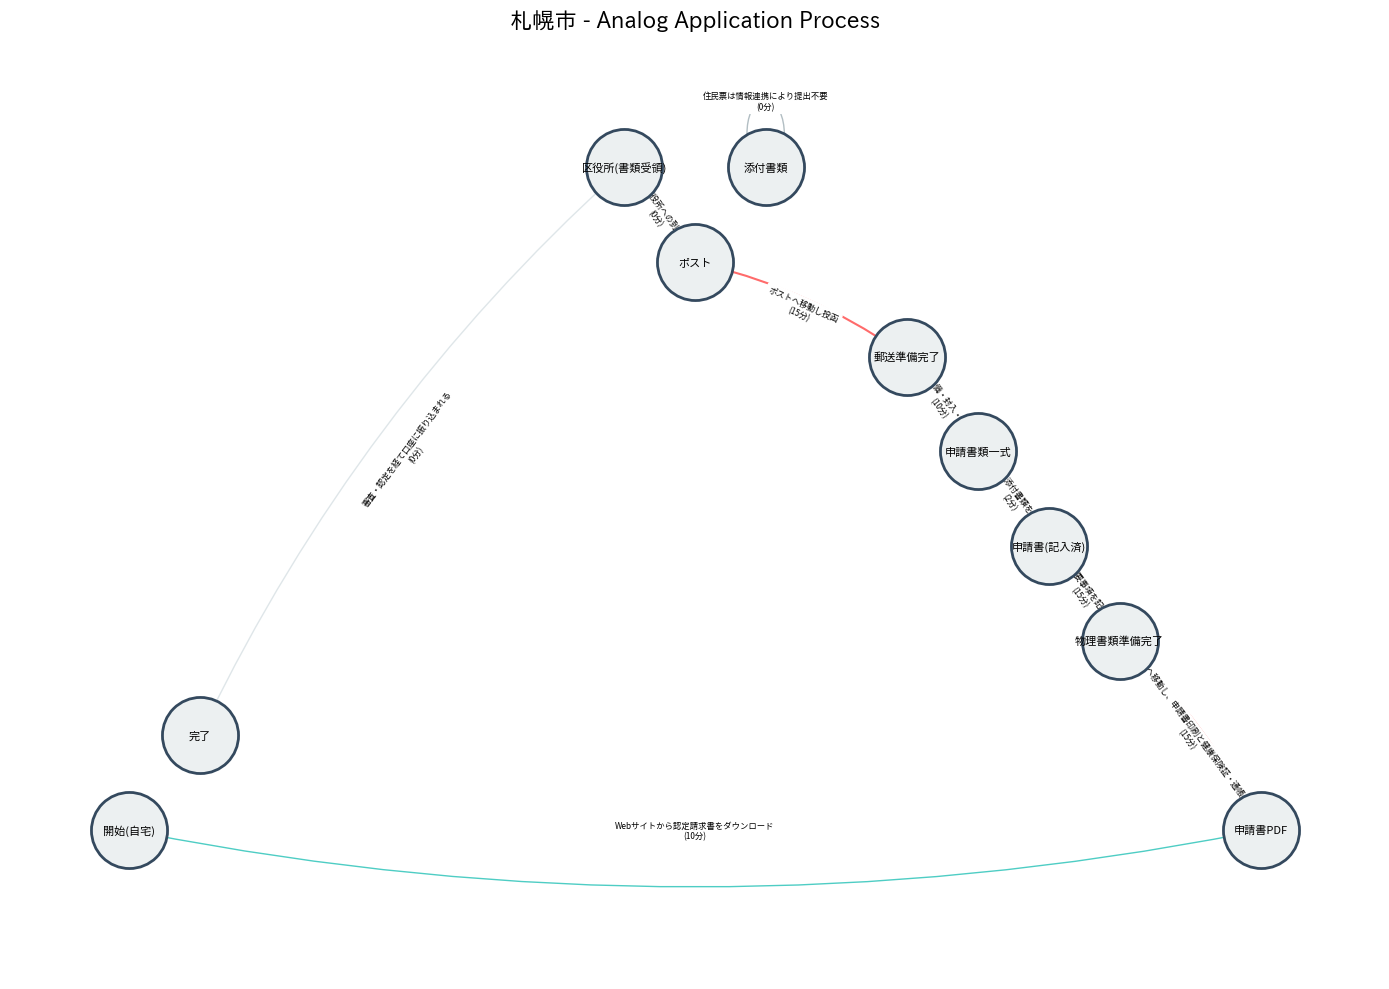

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/01100_digital_graph.png


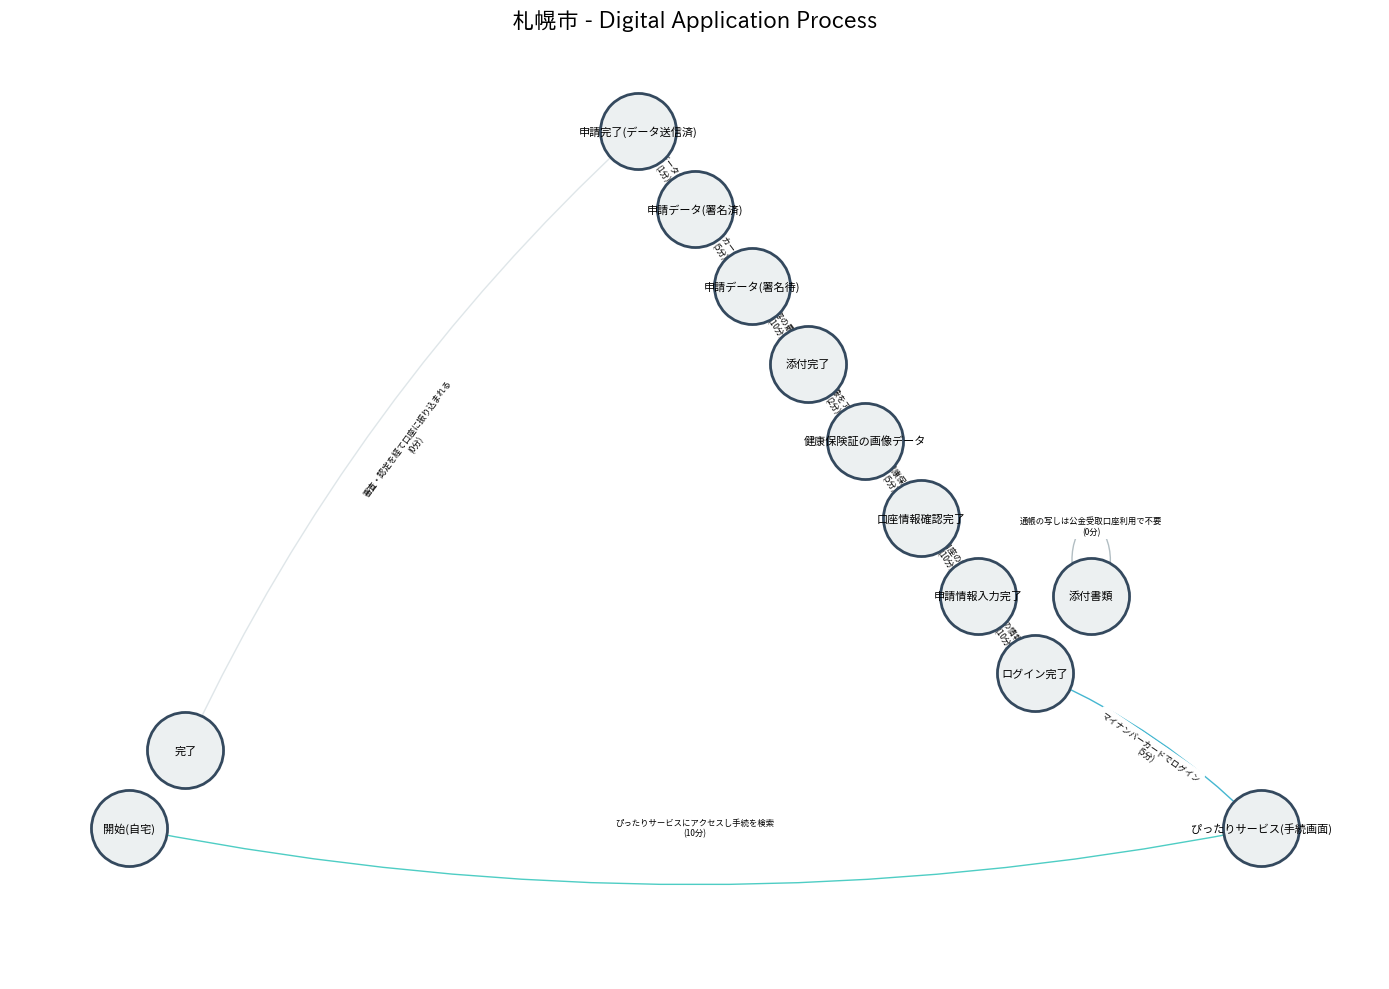

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/04100_analog_graph.png


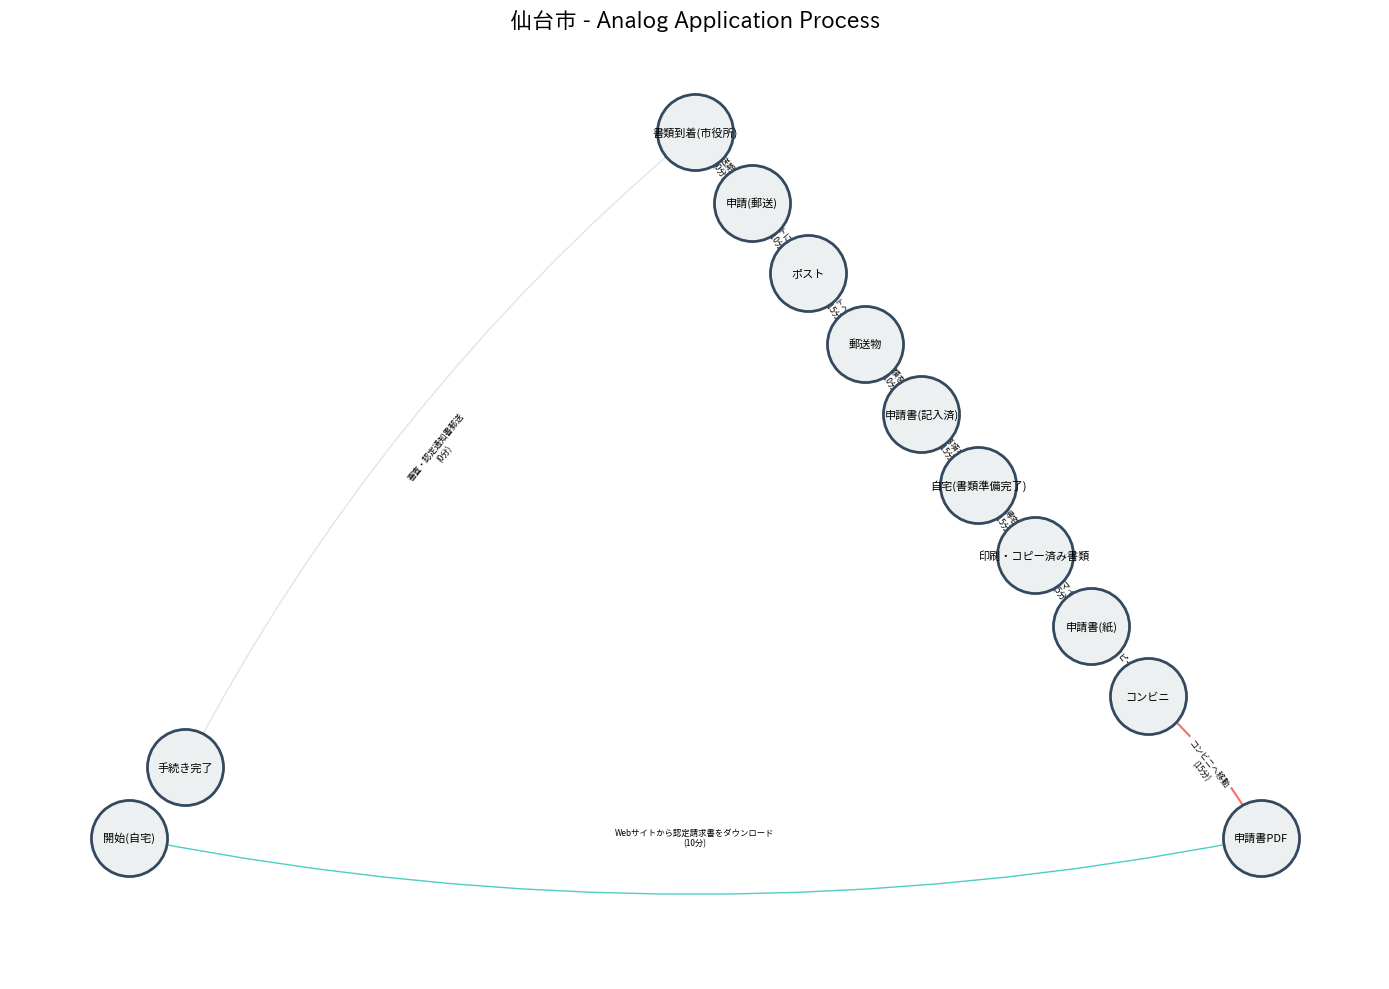

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/04100_digital_graph.png


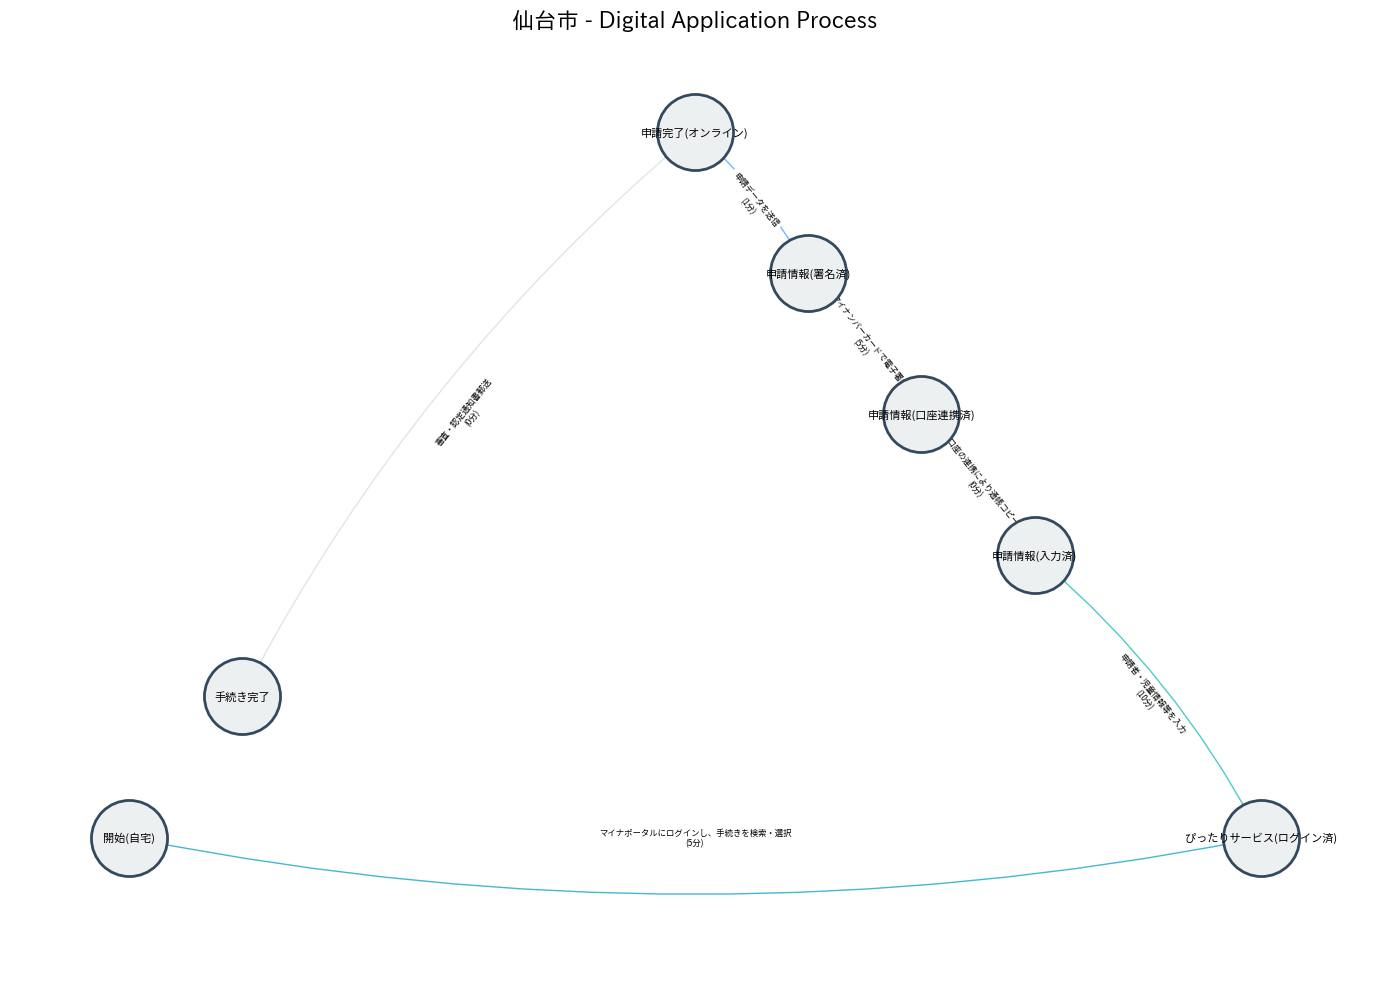

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13105_analog_graph.png


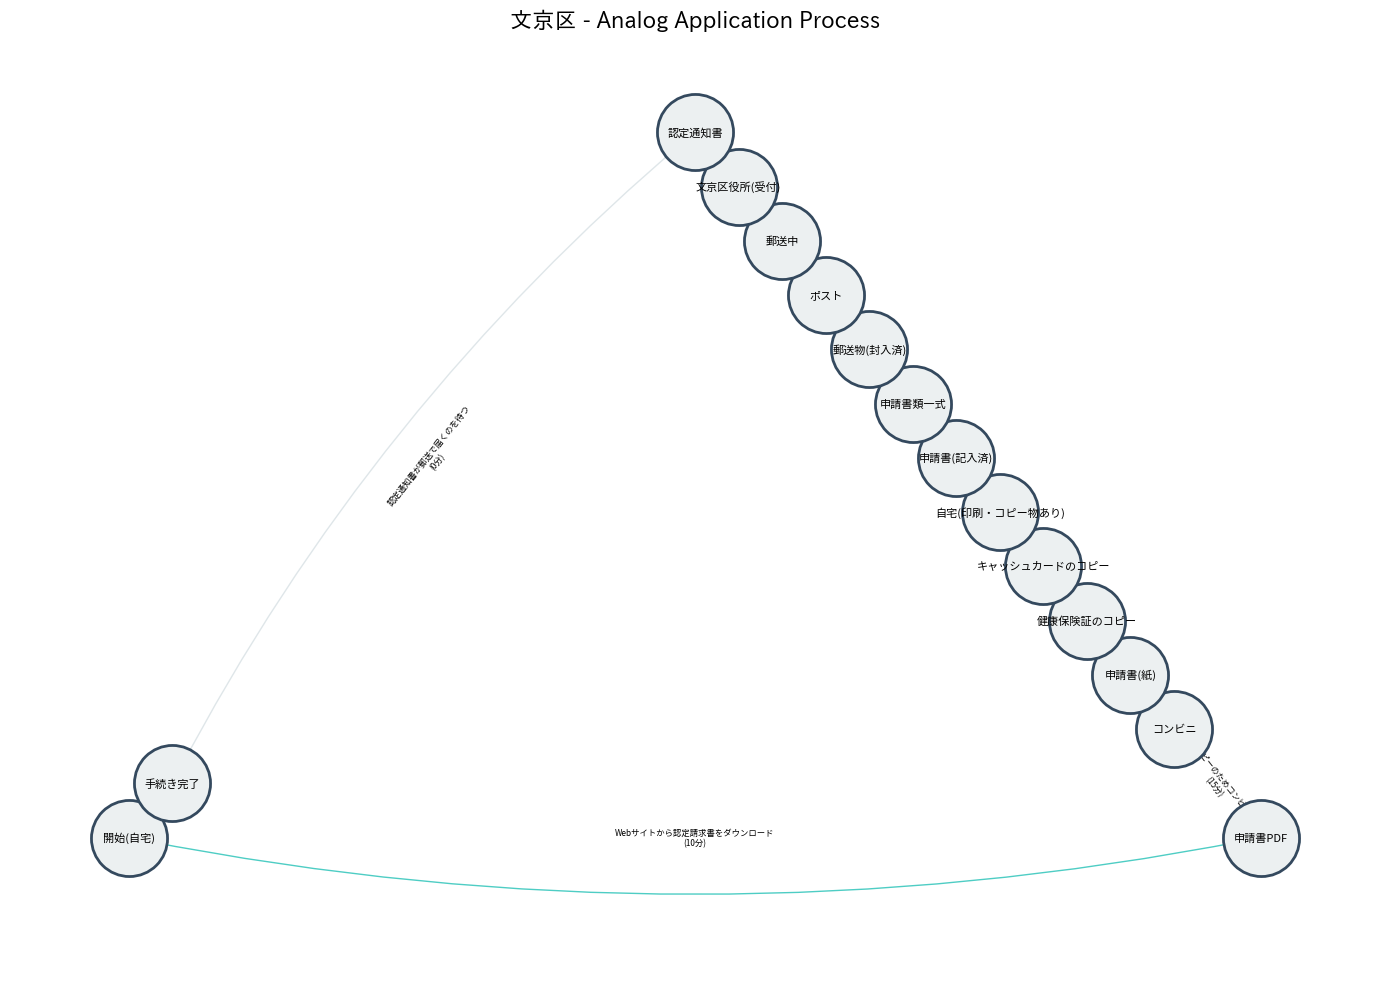

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13105_digital_graph.png


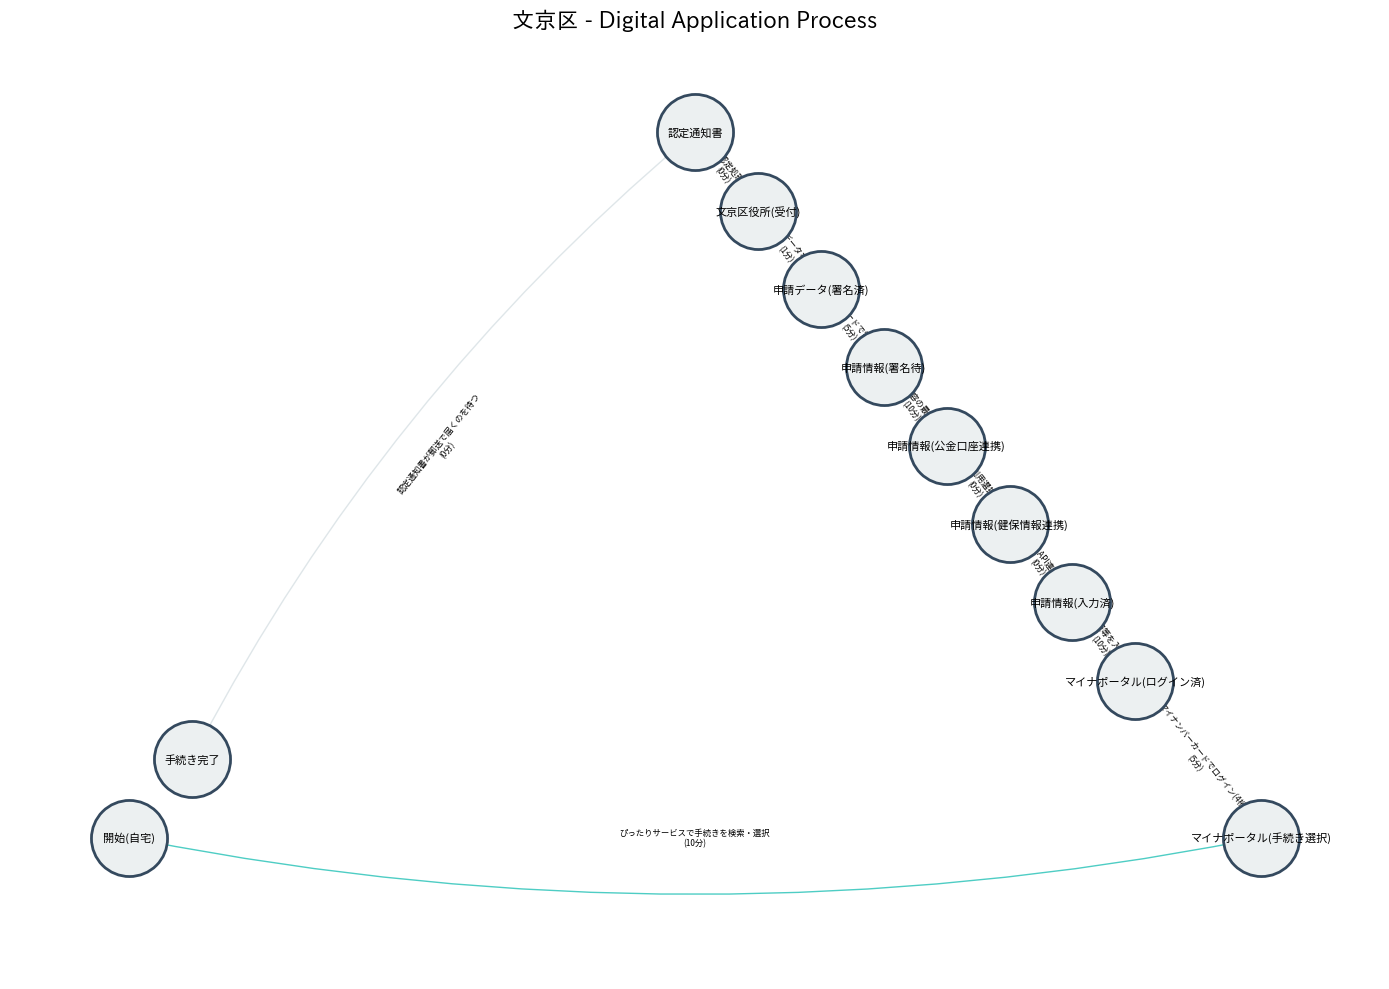

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13112_analog_graph.png


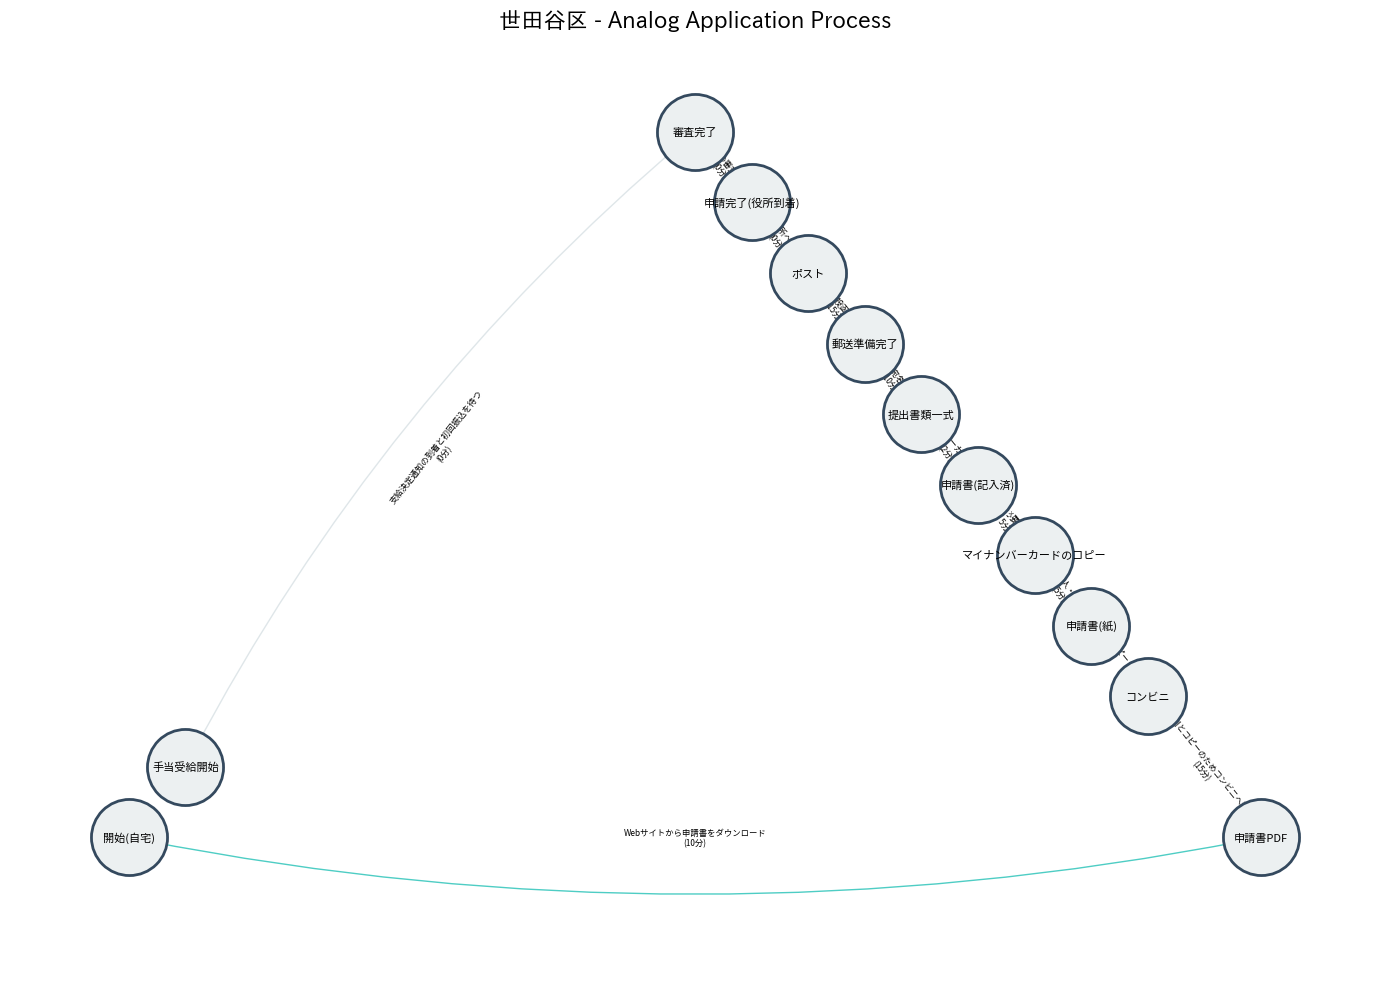

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13112_digital_graph.png


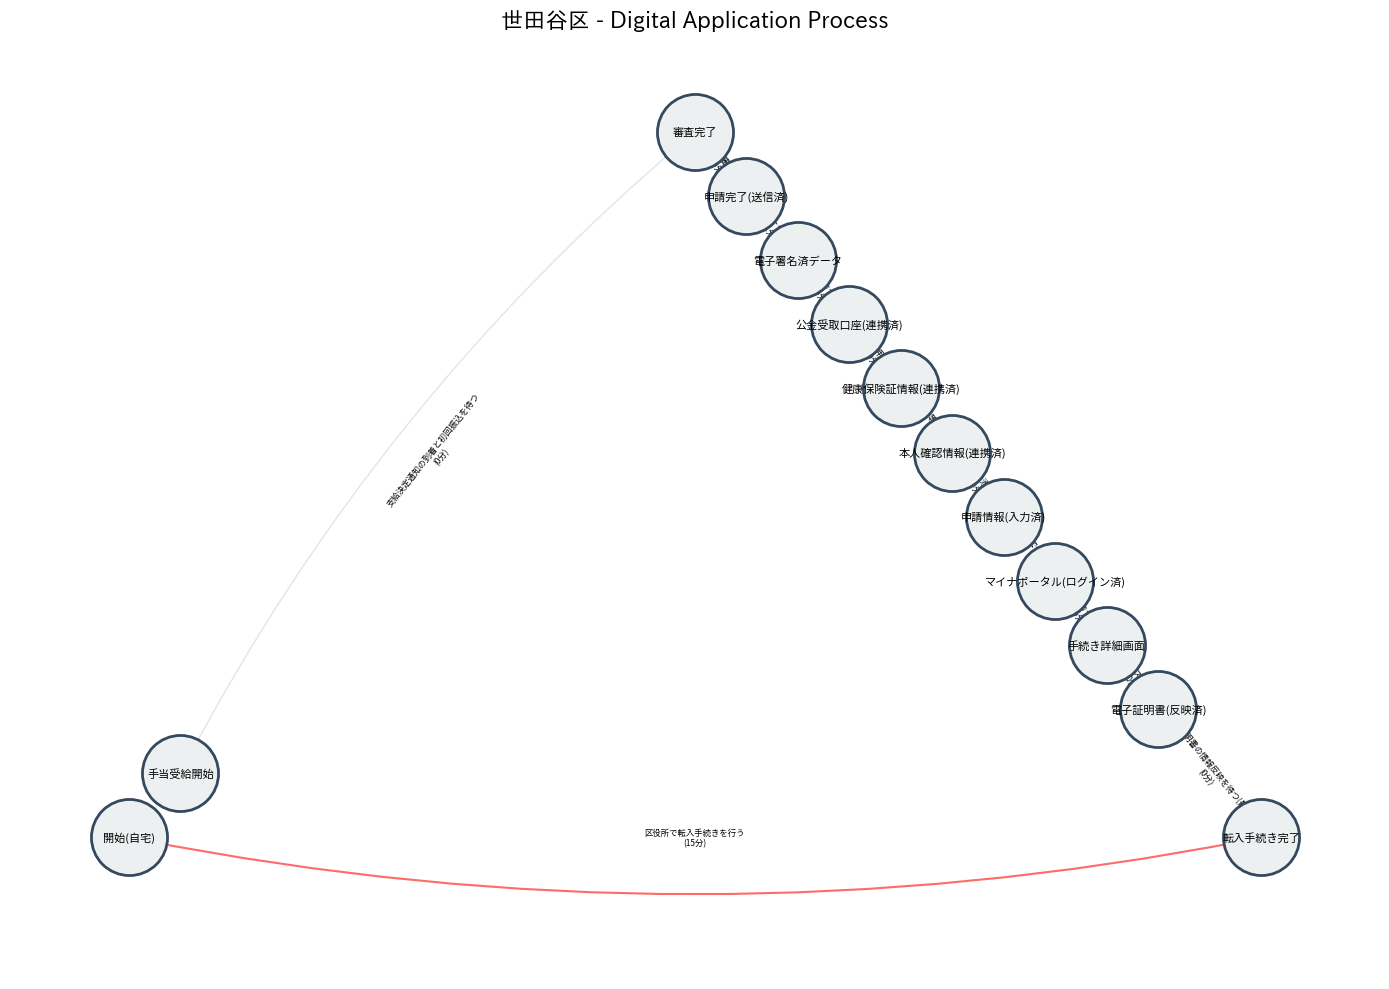

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13103_analog_graph.png


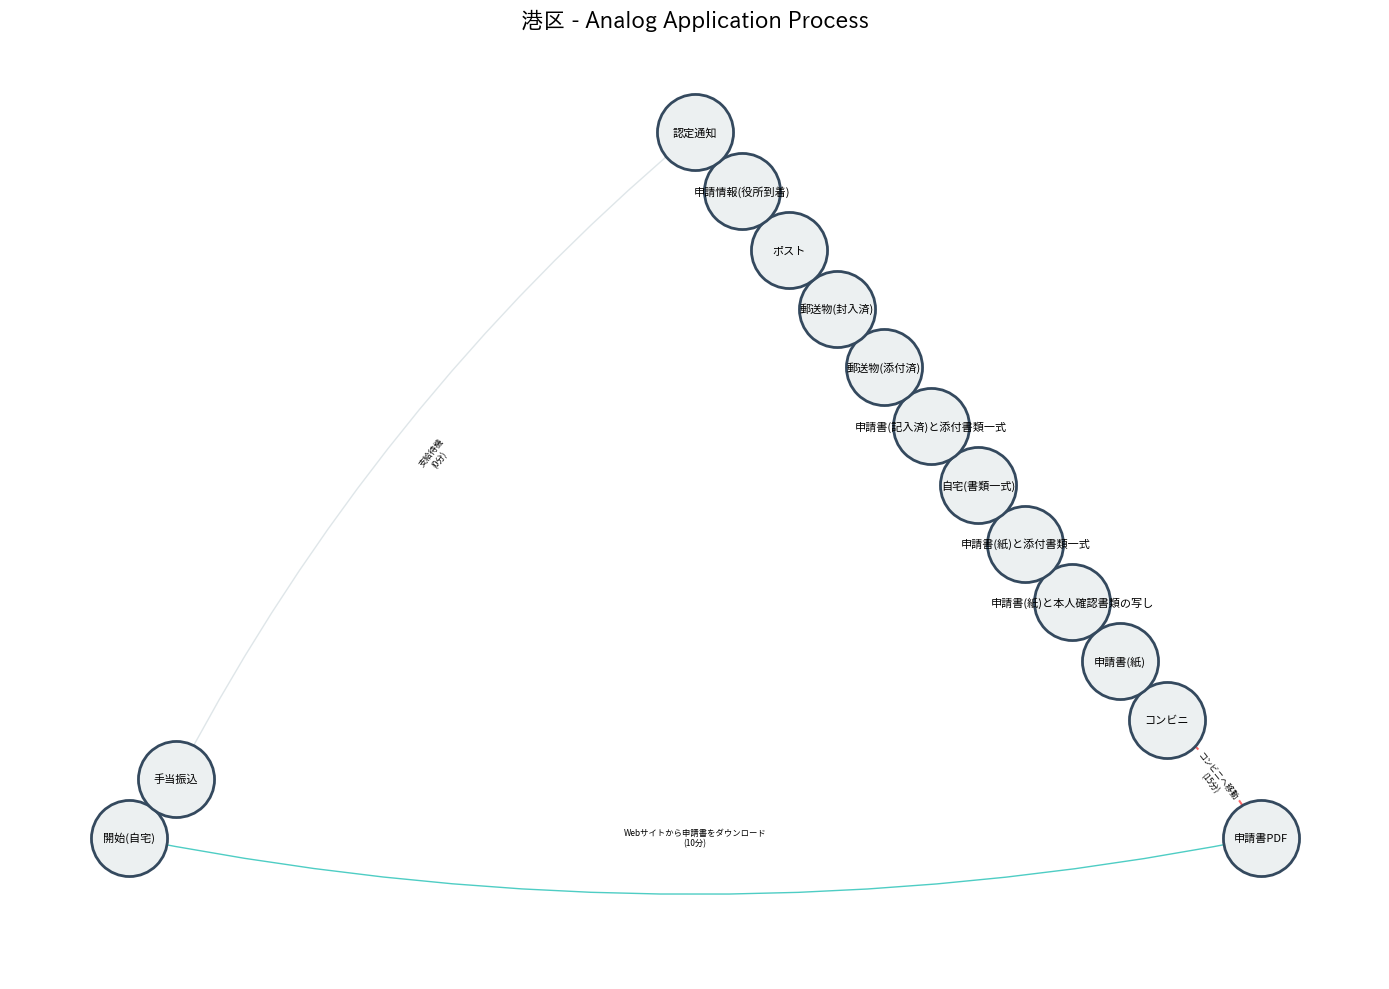

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13103_digital_graph.png


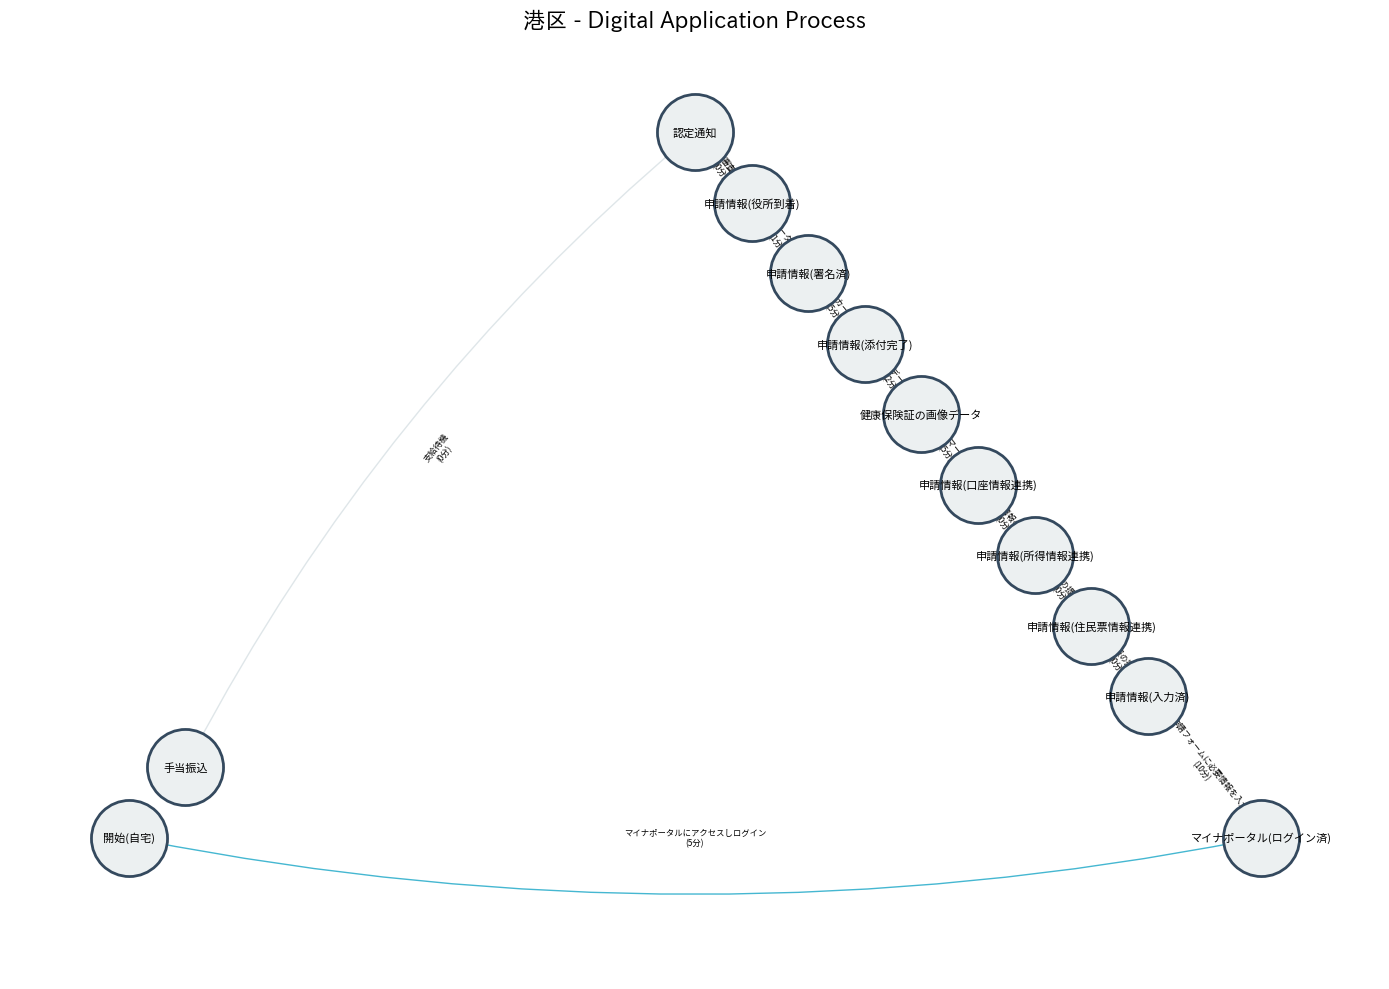

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13113_analog_graph.png


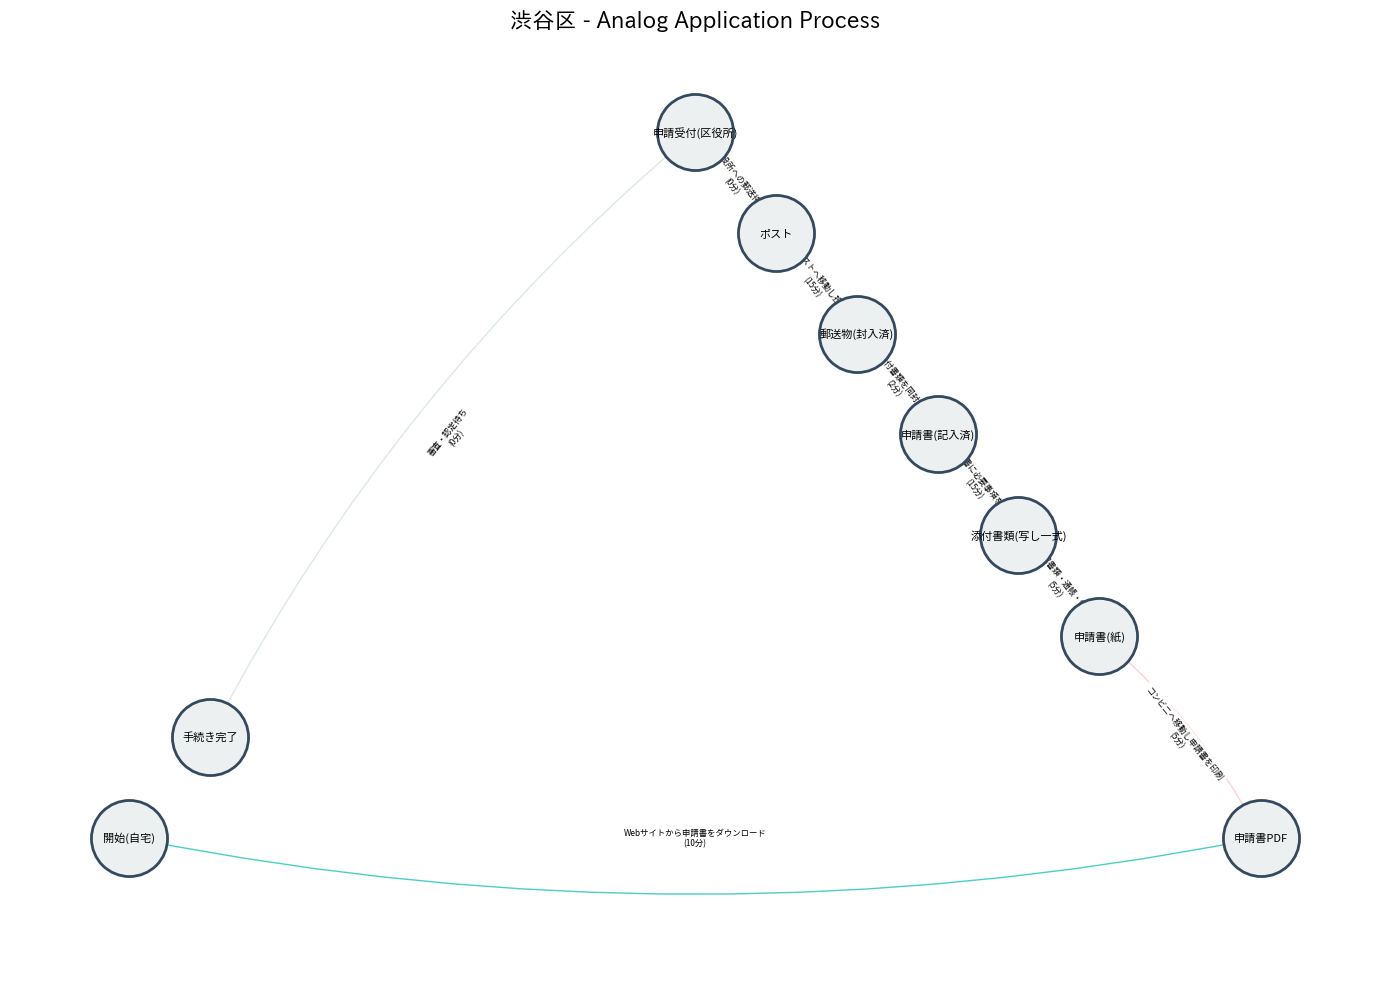

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13113_digital_graph.png


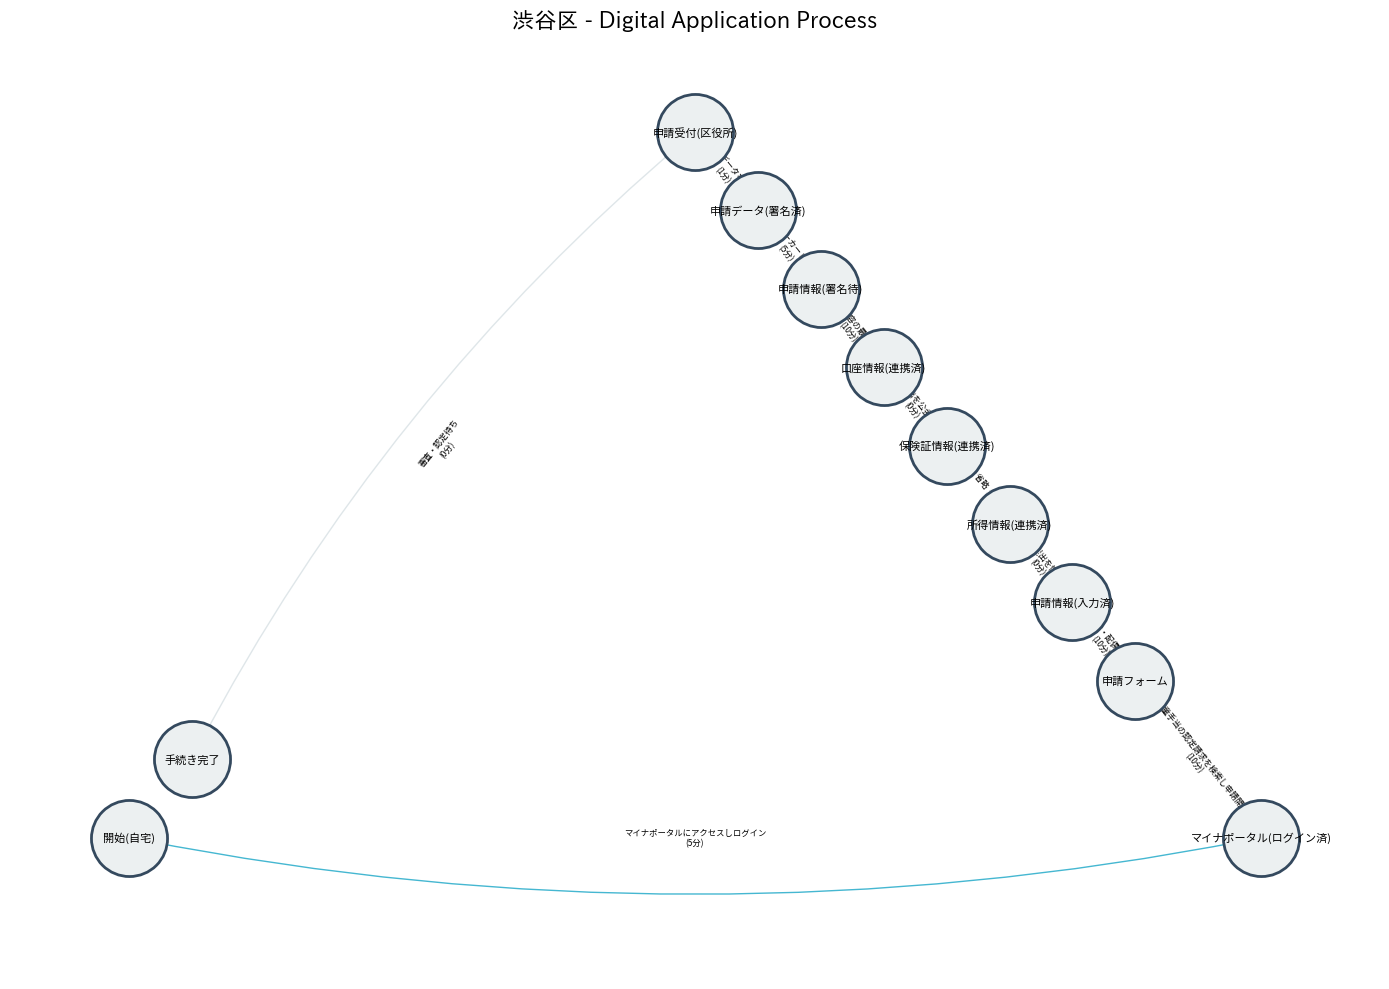

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13121_analog_graph.png


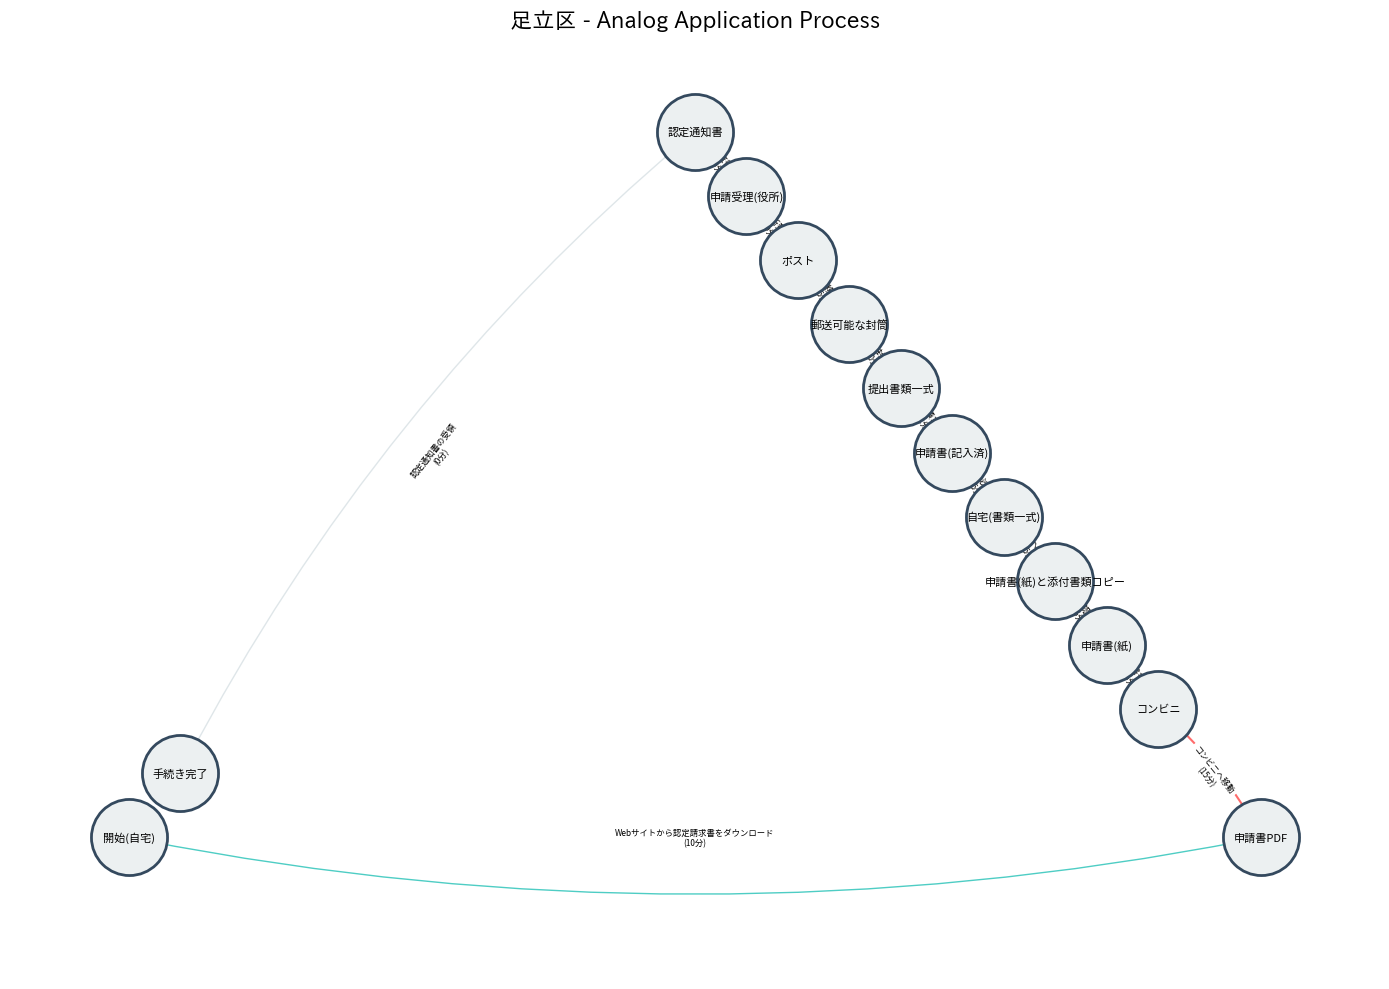

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/13121_digital_graph.png


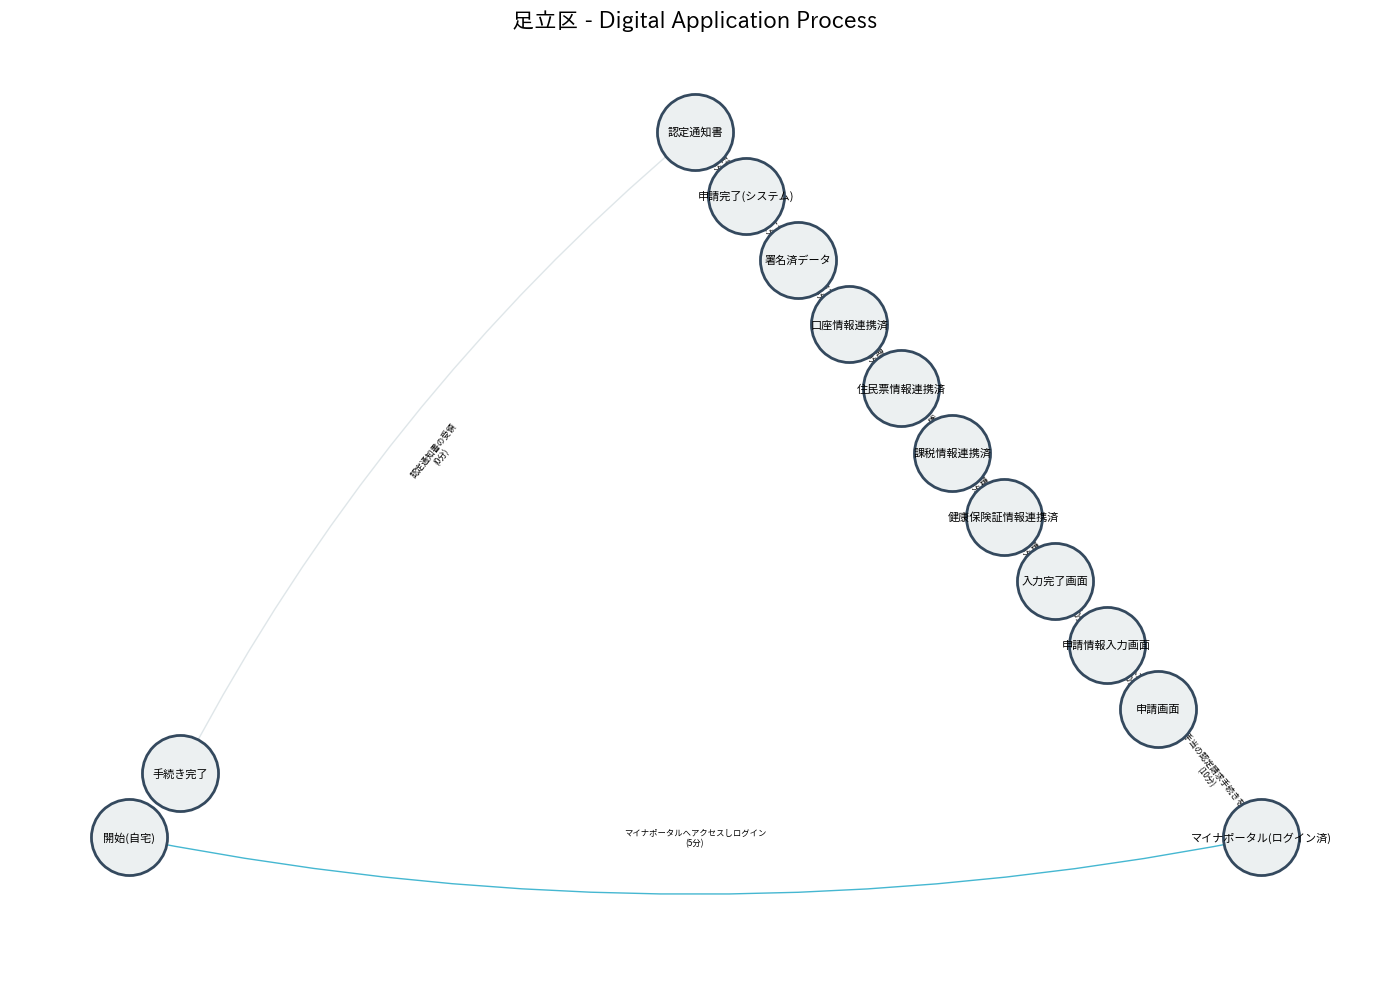

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/23100_analog_graph.png


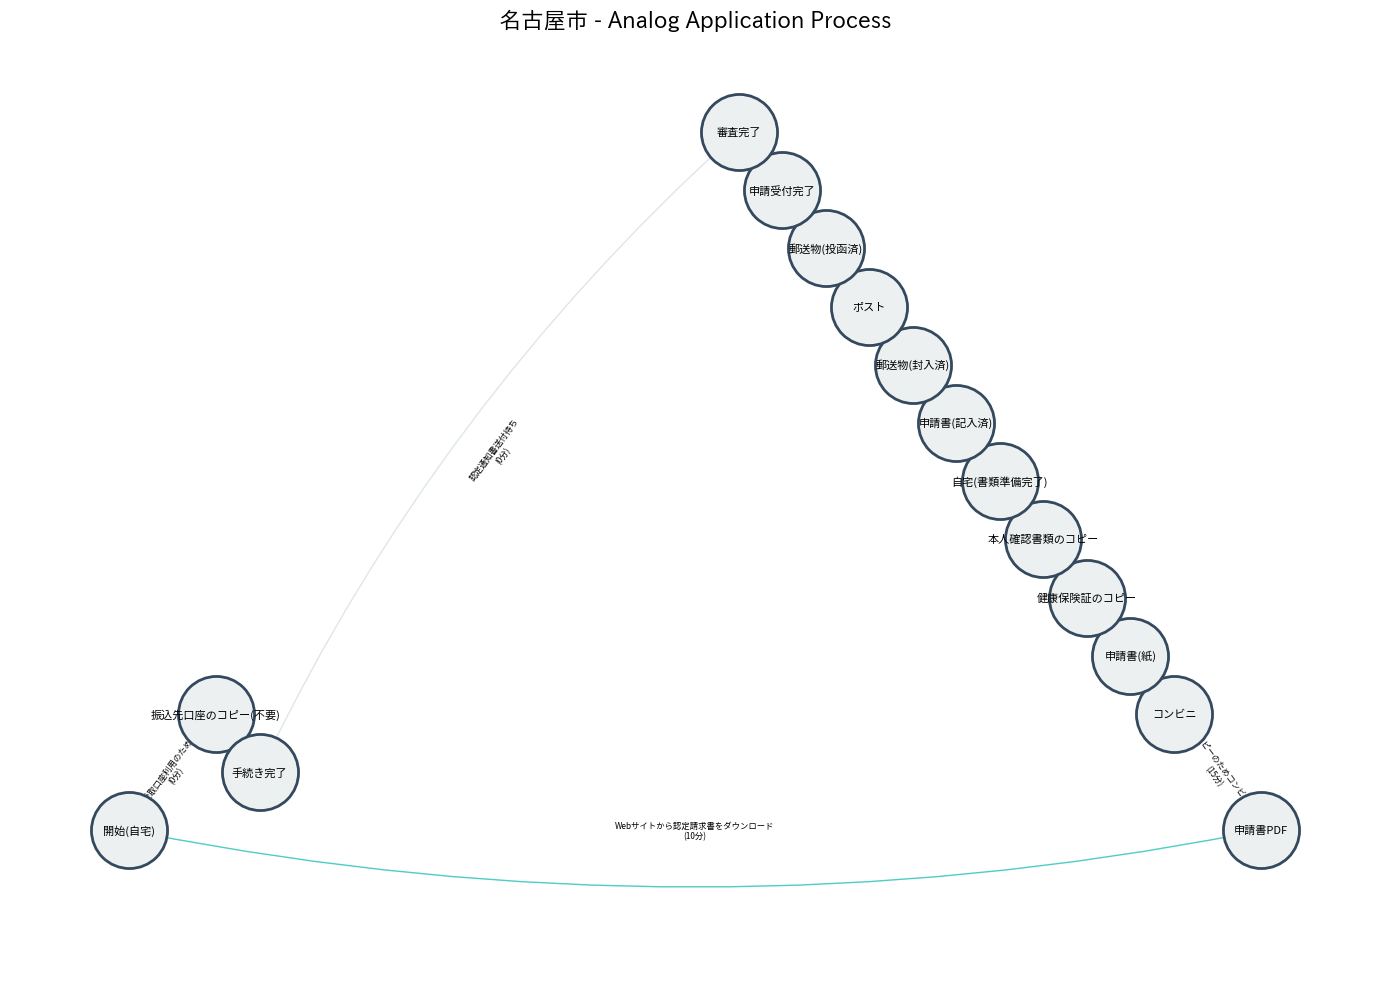

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/23100_digital_graph.png


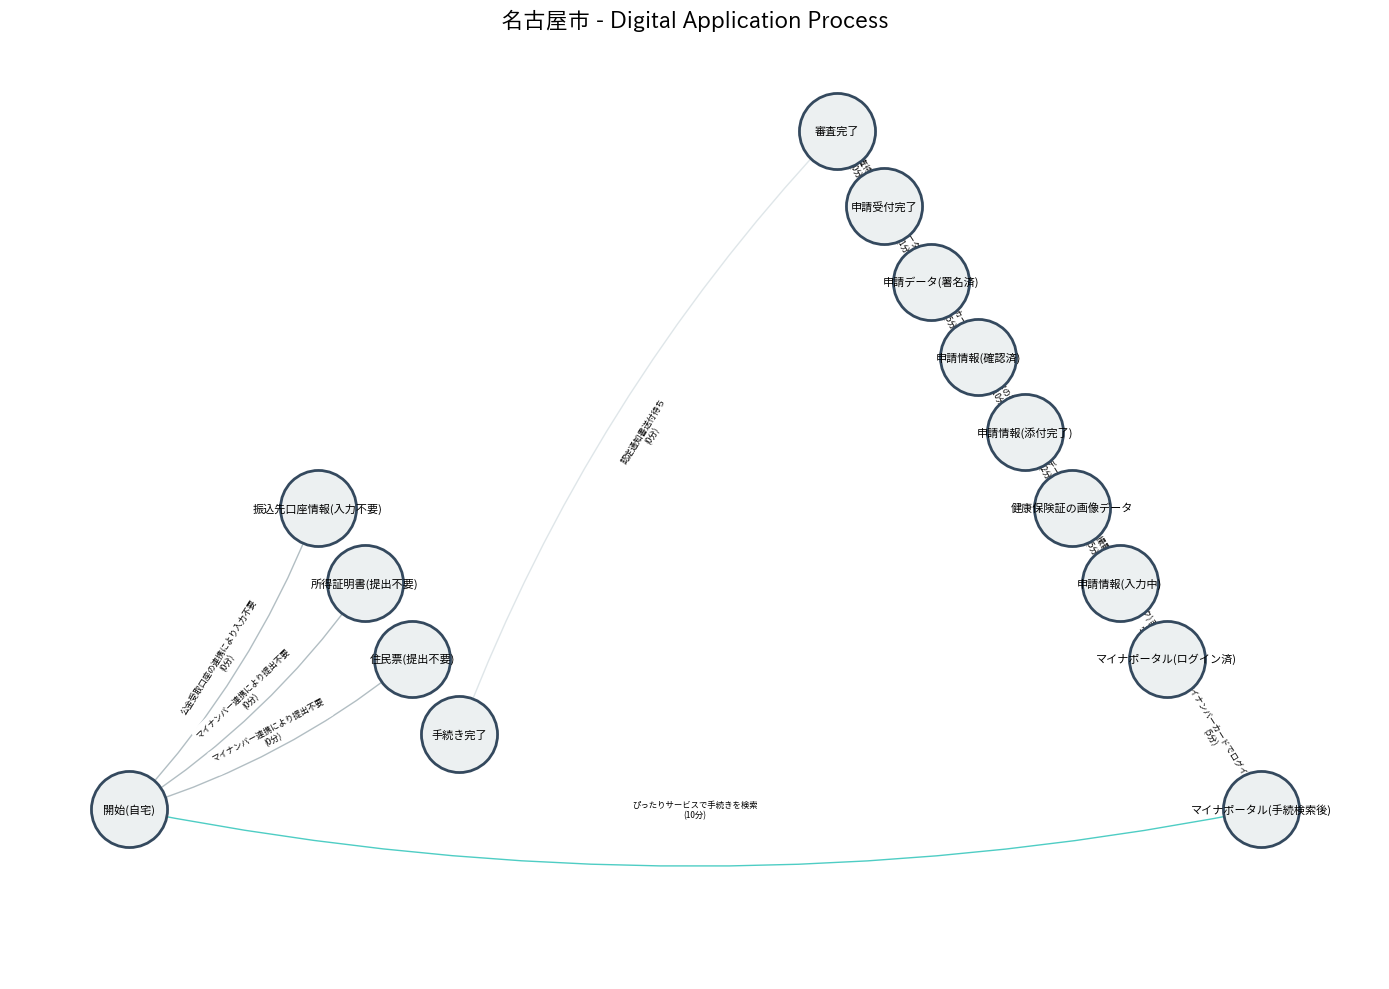

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/27100_analog_graph.png


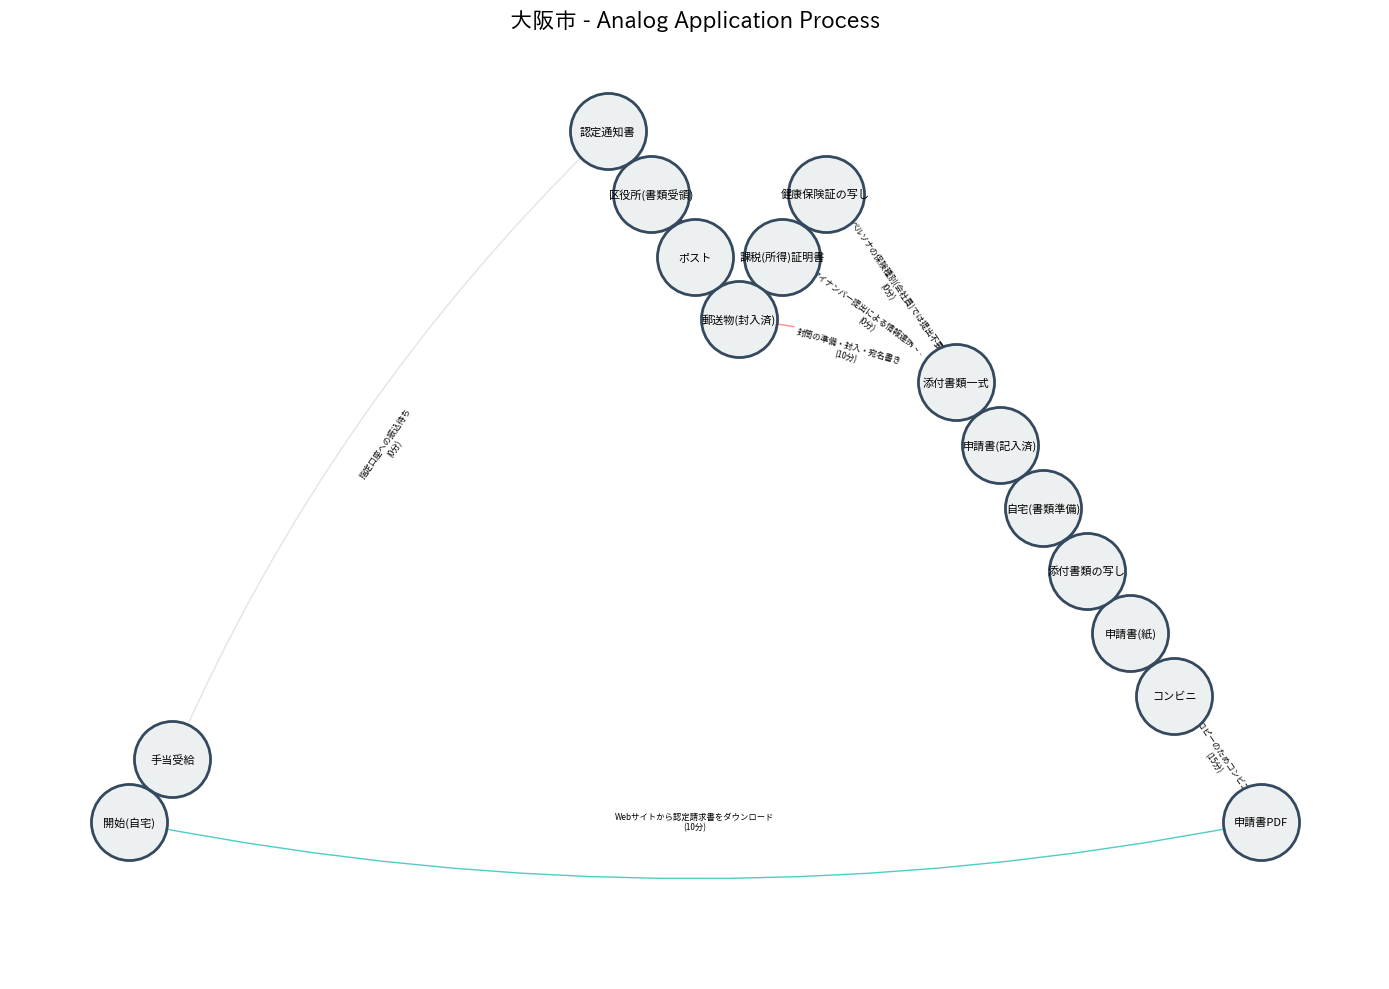

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/27100_digital_graph.png


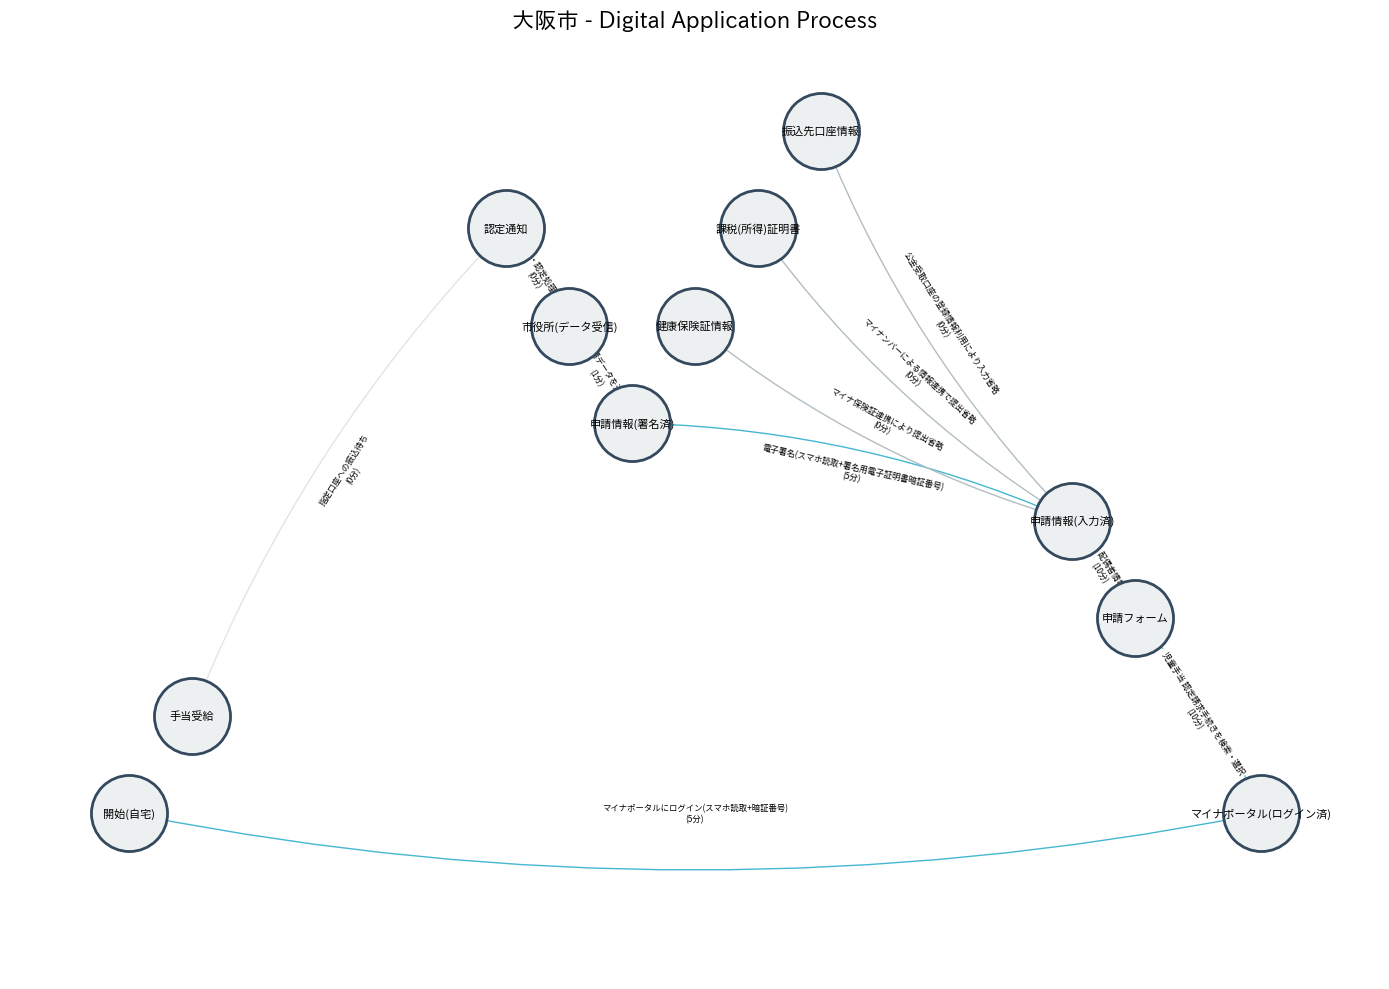

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/34100_analog_graph.png


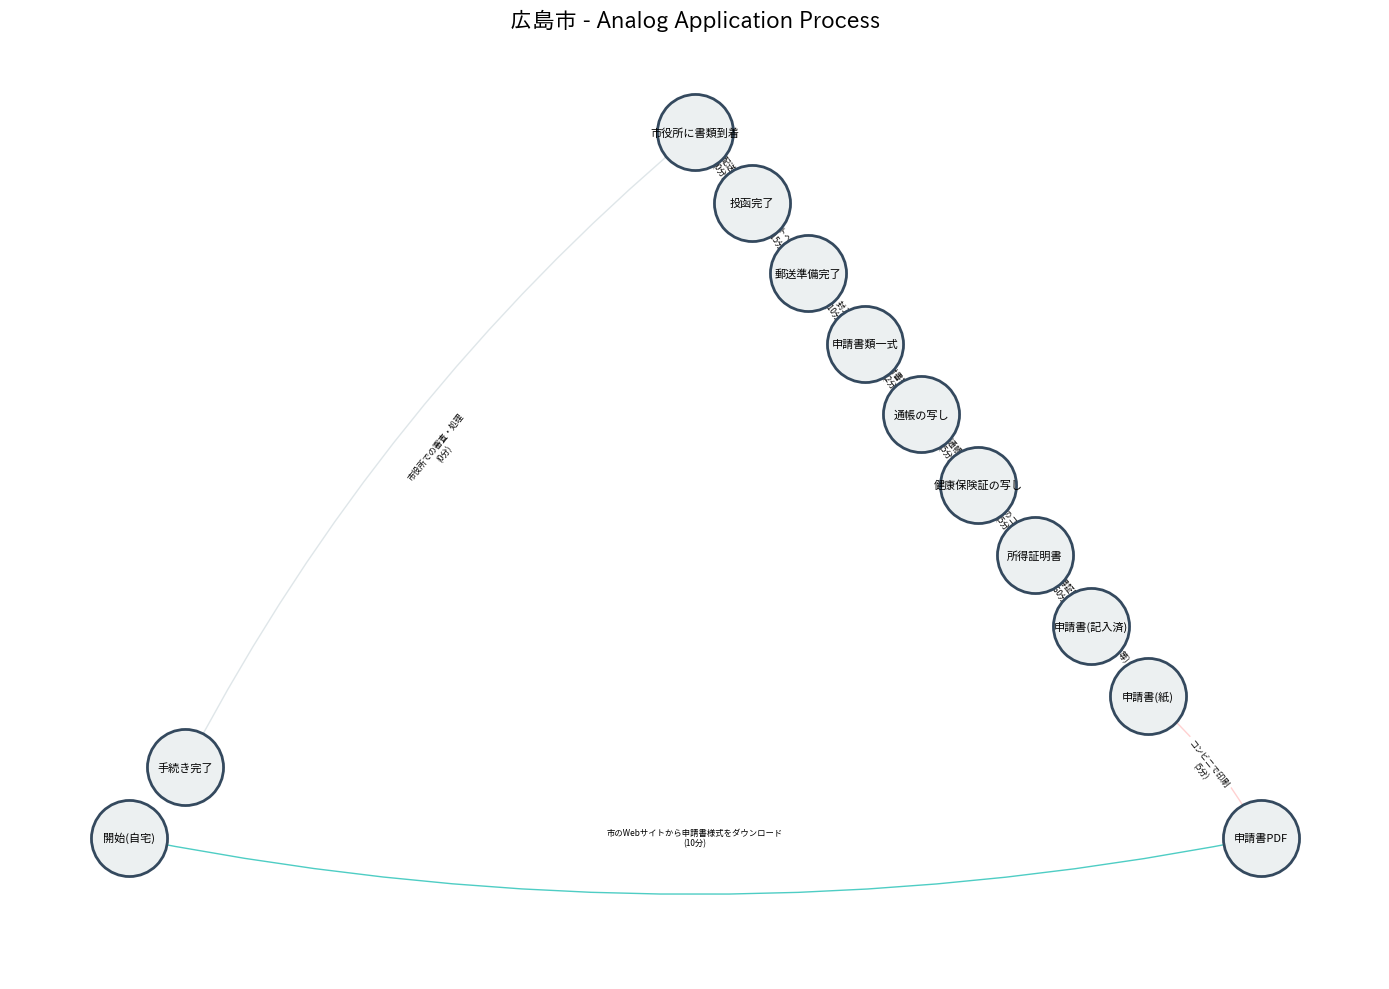

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/34100_digital_graph.png


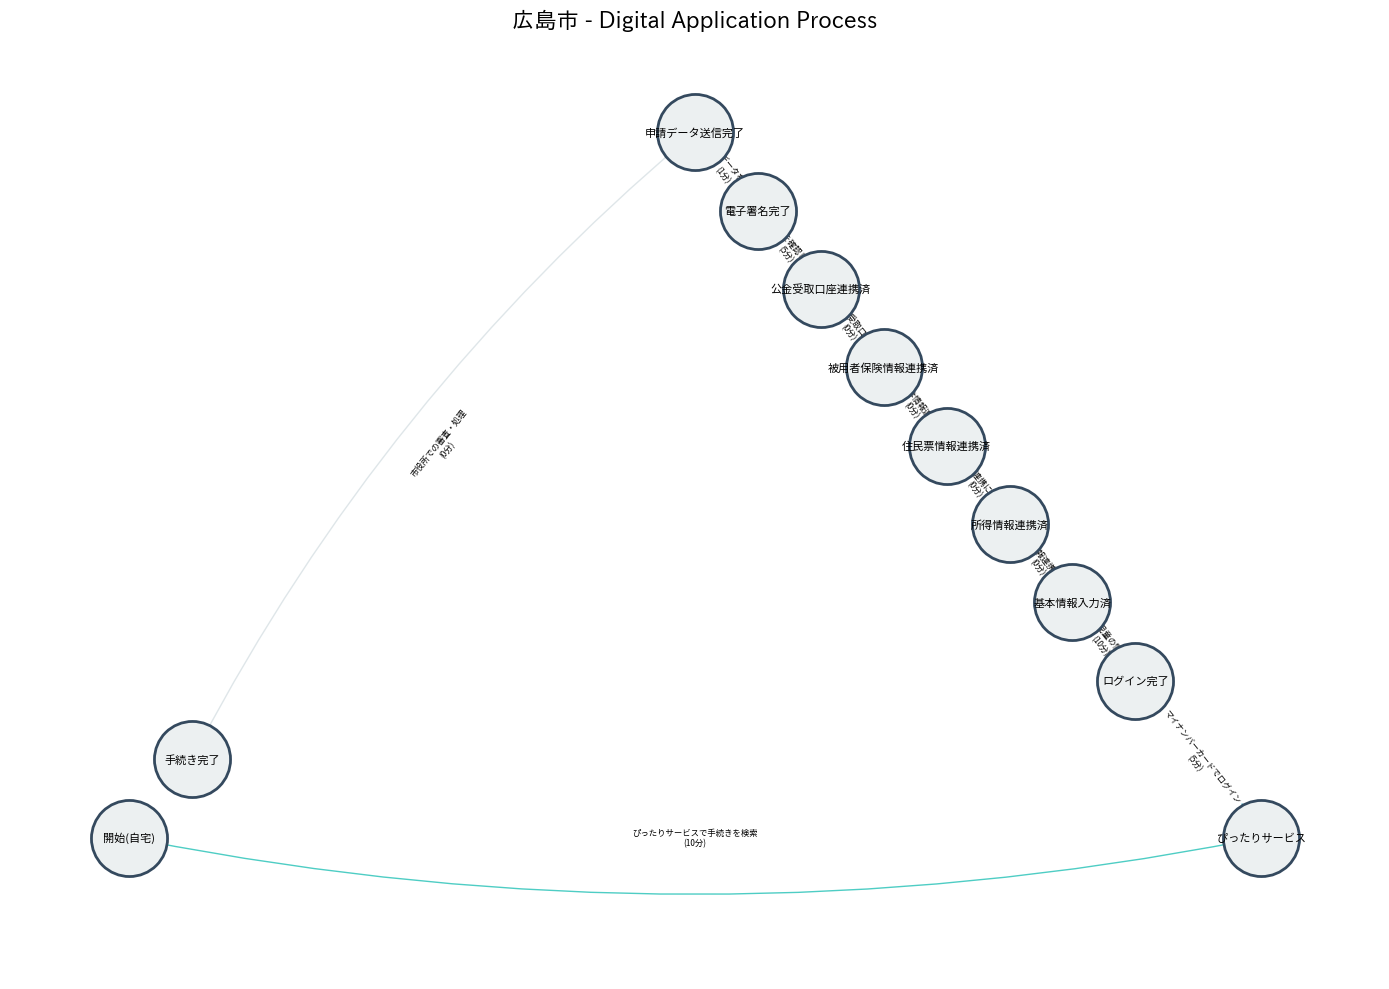

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/40130_analog_graph.png


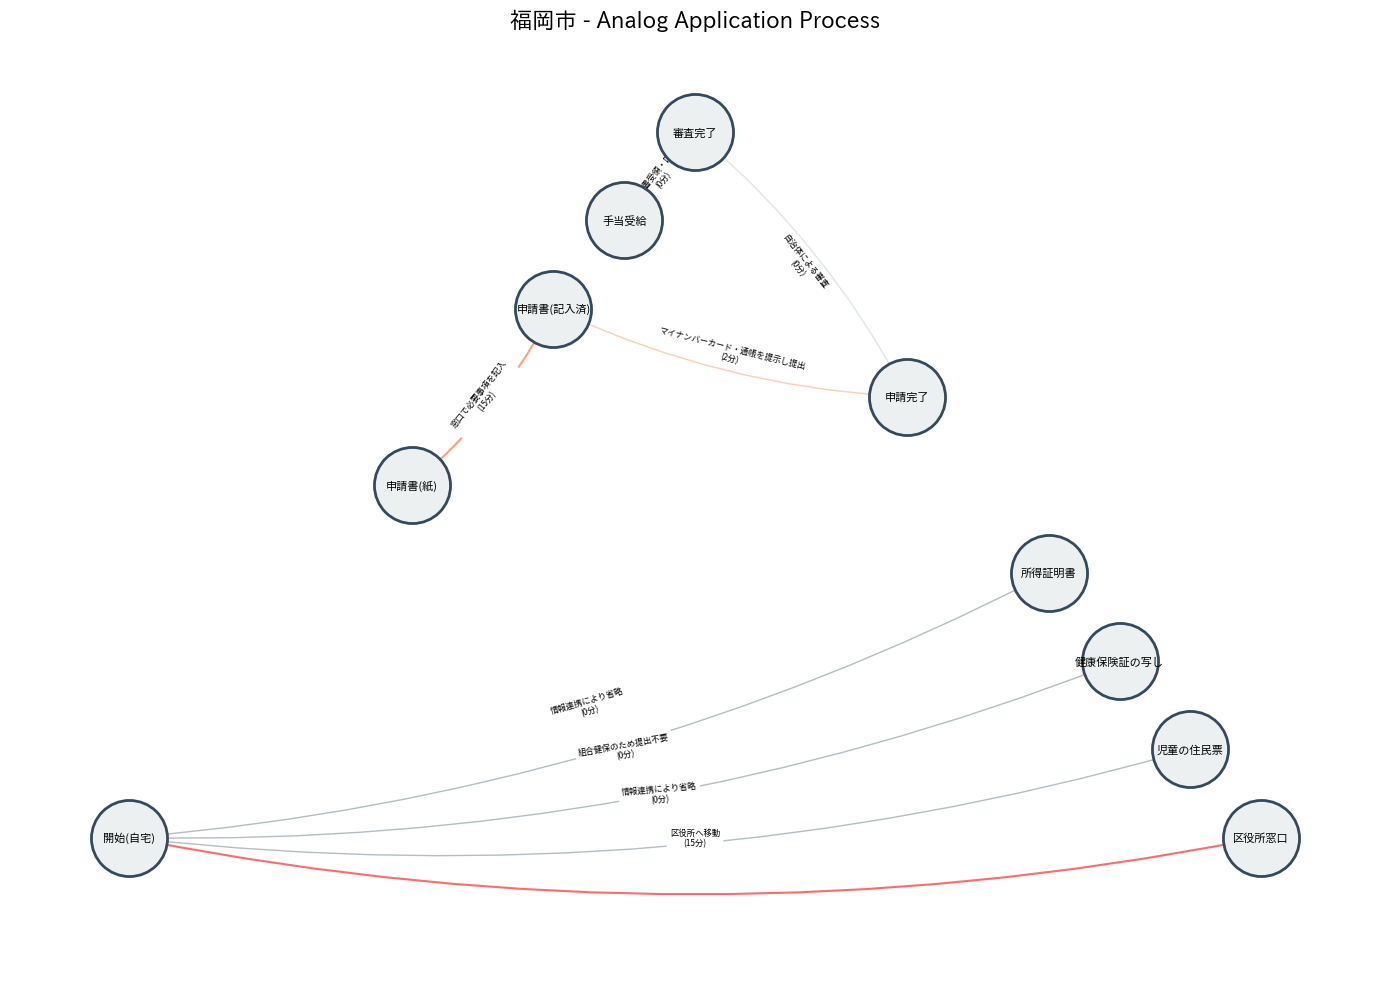

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/40130_digital_graph.png


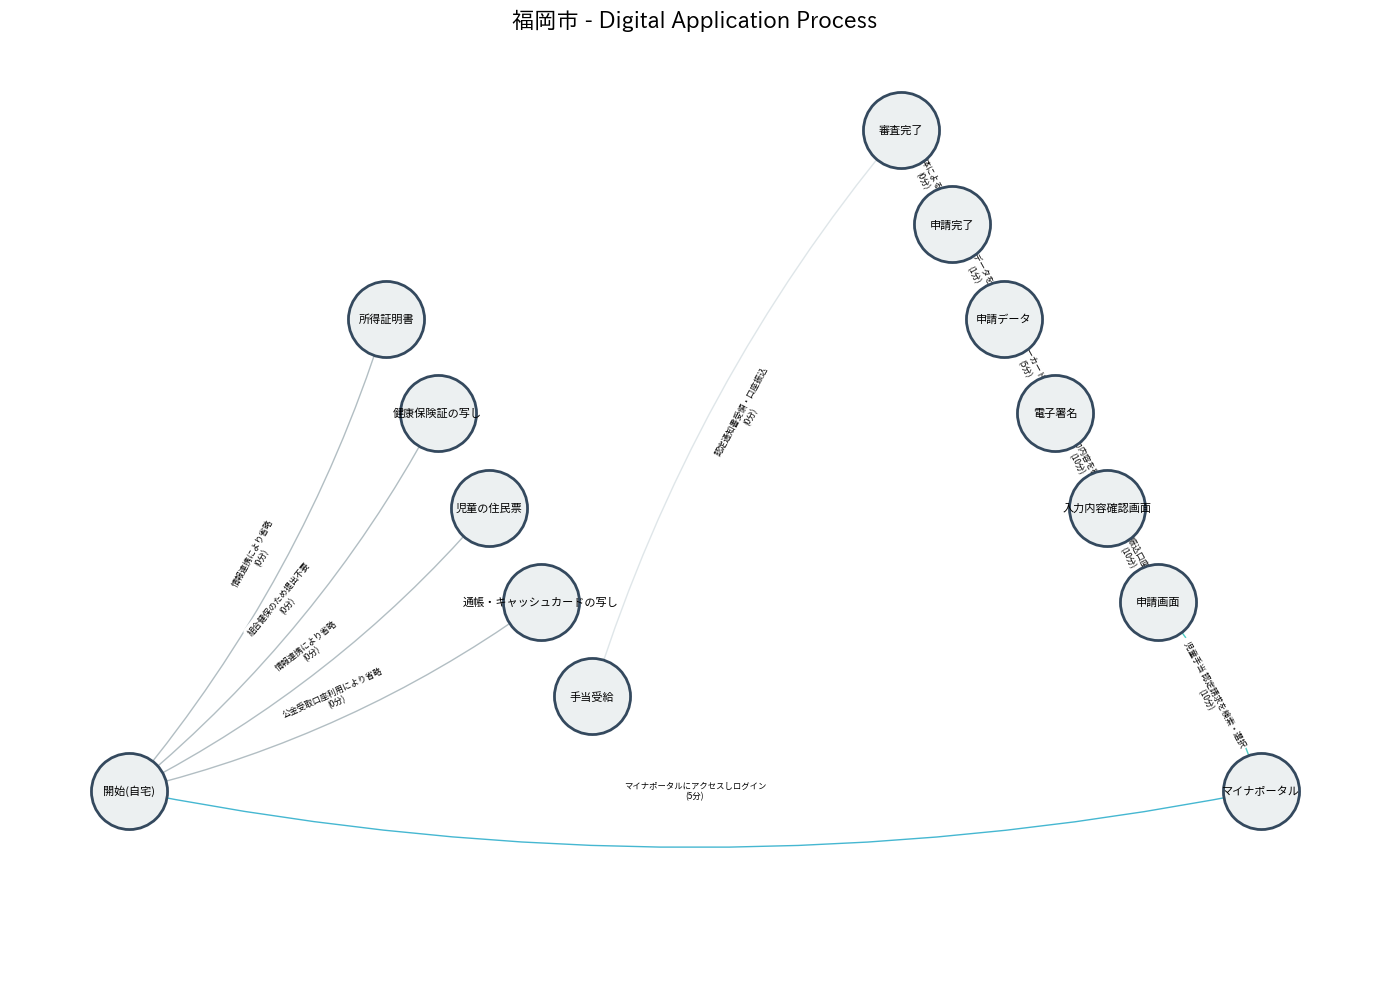

In [13]:
def visualize_graph(G: nx.DiGraph, title: str, output_file: str = None):
    """グラフを可視化"""
    plt.figure(figsize=(14, 10))
    
    # レイアウト計算
    pos = nx.planar_layout(G, scale=1, center=None, dim=2)
    # pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # エッジの色をタイプに応じて設定
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        action_type = data.get("type", "No_Action")
        edge_colors.append(TYPE_COLORS.get(action_type, "#95A5A6"))
        # コストに応じてエッジの太さを変更
        cost = data.get("cost", 0)
        edge_widths.append(max(1, cost / 10))
    
    # ノード描画
    nx.draw_networkx_nodes(G, pos, node_color="#ECF0F1", node_size=3000, 
                          edgecolors="#34495E", linewidths=2)
    
    # エッジ描画
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths,
                          arrowsize=20, arrowstyle="->", connectionstyle="arc3,rad=0.1")
    
    # ラベル描画
    nx.draw_networkx_labels(G, pos, font_size=8, font_family="Noto Sans CJK JP")
    
    # エッジラベル（アクション名）
    edge_labels = {(u, v): f"{data['action']}\n({data['cost']}分)" 
                   for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6, font_family="Noto Sans CJK JP")
    
    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.axis("off")
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved: {output_file}")
    
    plt.show()

# 各自治体のグラフを可視化
for city_id, data in all_data.items():
    city_name = data["name"]
    
    # アナログ申請グラフ
    visualize_graph(
        data["analog_graph"],
        f"{city_name} - Analog Application Process",
        config.OUTPUT_DIR / f"{city_id}_analog_graph.png"
    )
    
    # デジタル申請グラフ
    visualize_graph(
        data["digital_graph"],
        f"{city_name} - Digital Application Process",
        config.OUTPUT_DIR / f"{city_id}_digital_graph.png"
    )

## 4. コスト比較分析

In [14]:
# サマリーテーブル作成
summary_data = []
for city_id, data in all_data.items():
    summary_data.append({
        "自治体": data["name"],
        "アナログコスト(分)": data["analog_cost"],
        "デジタルコスト(分)": data["digital_cost"],
        "削減時間(分)": data["analog_cost"] - data["digital_cost"],
        "削減率(%)": data["reduction_rate"]
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("削減率(%)", ascending=False)
print("\n=== コスト削減サマリー ===")
print(summary_df.to_string(index=False))
summary_df.to_csv(f"{config.OUTPUT_DIR}/cost_summary.csv", index=False, encoding="utf-8-sig")


=== コスト削減サマリー ===
 自治体  アナログコスト(分)  デジタルコスト(分)  削減時間(分)     削減率(%)
 仙台市         100          21       79  79.000000
 広島市         127          31       96  75.590551
  港区          97          28       69  71.134021
 大阪市          92          31       61  66.304348
 文京区         107          41       66  61.682243
 足立区          92          41       51  55.434783
名古屋市          97          48       49  50.515464
世田谷区          77          46       31  40.259740
 渋谷区          52          41       11  21.153846
 札幌市          67          58        9  13.432836
 福岡市          32          41       -9 -28.125000


## 5. 詳細分析

### 5.1 要因分解（積み上げ棒グラフ）

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/cost_breakdown.png


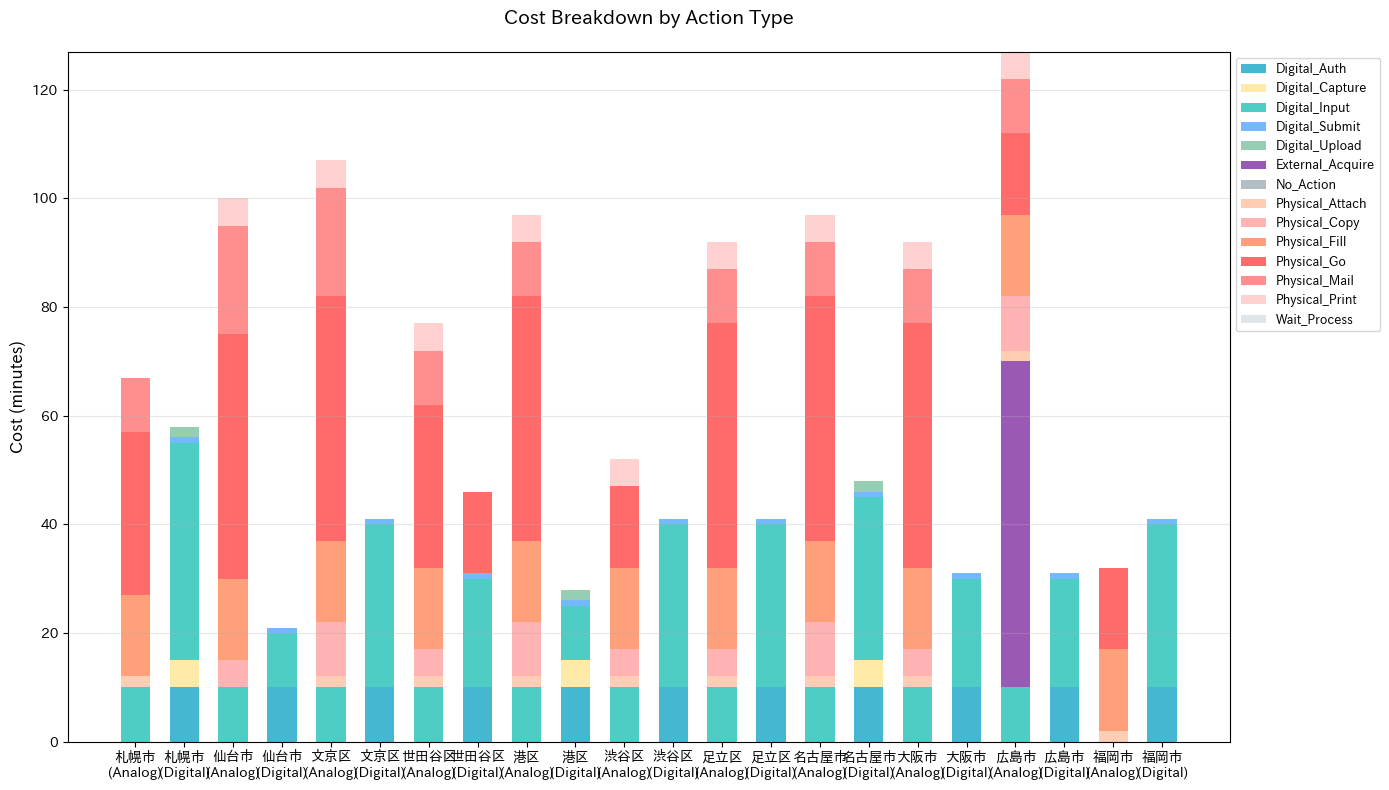

In [15]:
def plot_cost_breakdown():
    """コスト内訳の積み上げ棒グラフ"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    city_names = [data["name"] for data in all_data.values()]
    x_labels = []
    for name in city_names:
        x_labels.extend([f"{name}\n(Analog)", f"{name}\n(Digital)"])
    
    x_pos = np.arange(len(x_labels))
    
    # 全アクションタイプを収集
    all_types = set()
    for data in all_data.values():
        all_types.update(data["analog_breakdown"].keys())
        all_types.update(data["digital_breakdown"].keys())
    
    all_types = sorted(all_types)
    
    # 各タイプごとにバーを積み上げ
    bottom = np.zeros(len(x_labels))
    
    for action_type in all_types:
        values = []
        for data in all_data.values():
            values.append(data["analog_breakdown"].get(action_type, 0))
            values.append(data["digital_breakdown"].get(action_type, 0))
        
        color = TYPE_COLORS.get(action_type, "#95A5A6")
        ax.bar(x_pos, values, bottom=bottom, label=action_type, color=color, width=0.6)
        bottom += values
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.set_ylabel("Cost (minutes)", fontsize=12, fontweight="bold")
    ax.set_title("Cost Breakdown by Action Type", fontsize=14, fontweight="bold", pad=20)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9)
    ax.grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{config.OUTPUT_DIR}/cost_breakdown.png", dpi=300, bbox_inches="tight")
    print(f"Saved: {config.OUTPUT_DIR}/cost_breakdown.png")
    plt.show()

plot_cost_breakdown()

### 5.2 自治体ランキング

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/reduction_ranking.png


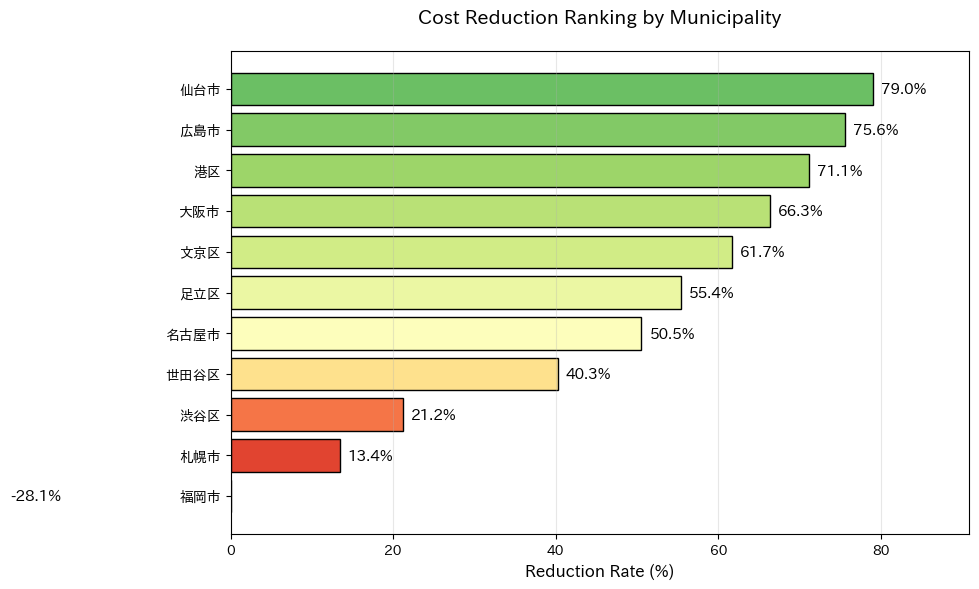

In [16]:
def plot_reduction_ranking():
    """削減率ランキングの横棒グラフ"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sorted_df = summary_df.sort_values("削減率(%)", ascending=True)
    
    colors = plt.cm.RdYlGn(sorted_df["削減率(%)"] / 100)
    
    bars = ax.barh(sorted_df["自治体"], sorted_df["削減率(%)"], color=colors, edgecolor="black")
    
    # バーに数値ラベルを追加
    for i, (idx, row) in enumerate(sorted_df.iterrows()):
        ax.text(row["削減率(%)"] + 1, i, f"{row['削減率(%)']:.1f}%", 
               va="center", fontsize=11, fontweight="bold")
    
    ax.set_xlabel("Reduction Rate (%)", fontsize=12, fontweight="bold")
    ax.set_title("Cost Reduction Ranking by Municipality", fontsize=14, fontweight="bold", pad=20)
    ax.grid(axis="x", alpha=0.3)
    ax.set_xlim(0, max(sorted_df["削減率(%)"]) * 1.15)
    
    plt.tight_layout()
    plt.savefig(f"{config.OUTPUT_DIR}/reduction_ranking.png", dpi=300, bbox_inches="tight")
    print(f"Saved: {config.OUTPUT_DIR}/reduction_ranking.png")
    plt.show()

plot_reduction_ranking()

### 5.3 散布図（アナログコスト vs デジタルコスト）

Saved: /home/rorok/eeic_lectures/3a/superD/admin-proc/output/scatter_comparison.png


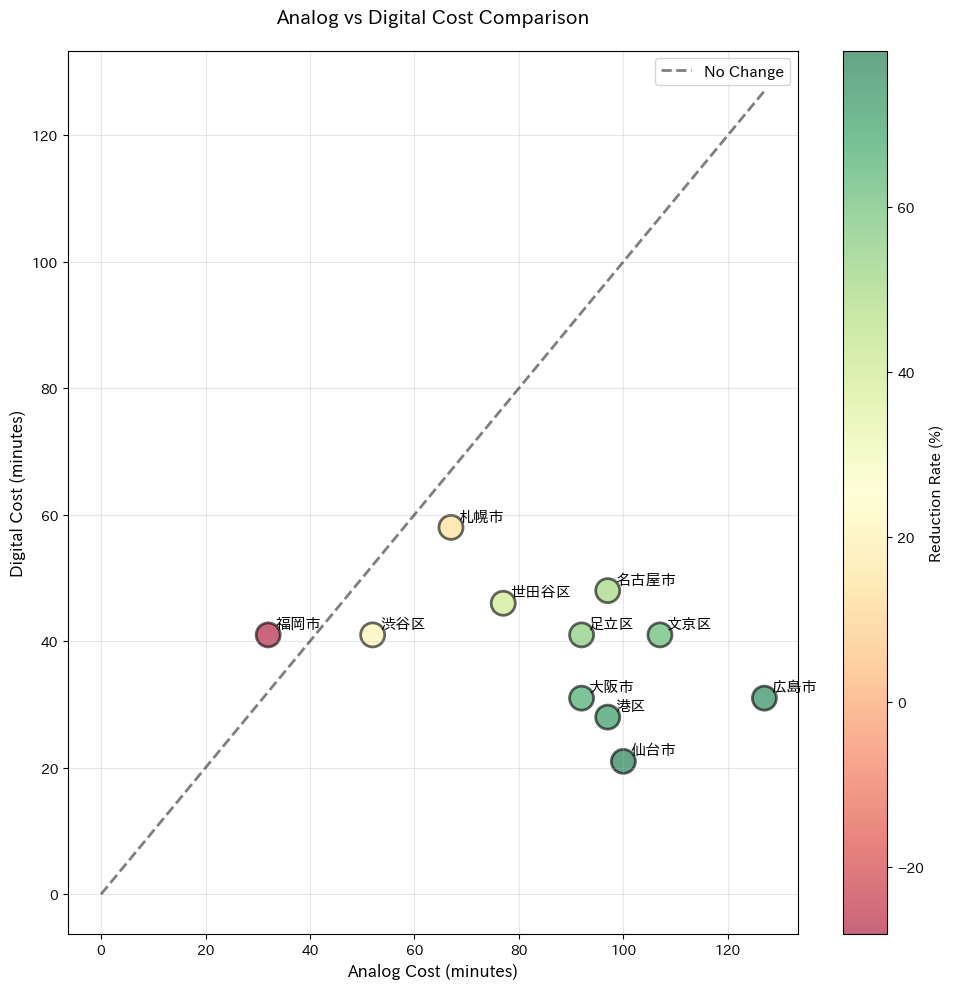

In [17]:
def plot_scatter_comparison():
    """アナログコスト vs デジタルコストの散布図"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    analog_costs = summary_df["アナログコスト(分)"].values
    digital_costs = summary_df["デジタルコスト(分)"].values
    city_names = summary_df["自治体"].values
    
    # 散布図
    scatter = ax.scatter(analog_costs, digital_costs, s=300, alpha=0.6, 
                        c=summary_df["削減率(%)"], cmap="RdYlGn", 
                        edgecolors="black", linewidth=2)
    
    # 自治体名をラベル表示
    for i, name in enumerate(city_names):
        ax.annotate(name, (analog_costs[i], digital_costs[i]), 
                   xytext=(5, 5), textcoords="offset points", fontsize=11, fontweight="bold")
    
    # 対角線（変化なしのライン）
    max_val = max(analog_costs.max(), digital_costs.max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label="No Change")
    
    ax.set_xlabel("Analog Cost (minutes)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Digital Cost (minutes)", fontsize=12, fontweight="bold")
    ax.set_title("Analog vs Digital Cost Comparison", fontsize=14, fontweight="bold", pad=20)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=11)
    
    # カラーバー
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Reduction Rate (%)", fontsize=11, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(f"{config.OUTPUT_DIR}/scatter_comparison.png", dpi=300, bbox_inches="tight")
    print(f"Saved: {config.OUTPUT_DIR}/scatter_comparison.png")
    plt.show()

plot_scatter_comparison()

## 6. 統計的検定

In [18]:
from scipy import stats

# 対応のあるt検定（アナログ vs デジタル）
analog_costs = summary_df["アナログコスト(分)"].values
digital_costs = summary_df["デジタルコスト(分)"].values

t_stat, p_value = stats.ttest_rel(analog_costs, digital_costs)

print("\n=== 統計的検定結果 ===")
print(f"対応のあるt検定: t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("→ 有意差あり (p < 0.05): デジタル化により有意にコストが削減されています")
else:
    print("→ 有意差なし (p >= 0.05)")

# 基本統計量
print("\n=== 基本統計量 ===")
print(f"アナログコスト: 平均={analog_costs.mean():.1f}分, 標準偏差={analog_costs.std():.1f}分")
print(f"デジタルコスト: 平均={digital_costs.mean():.1f}分, 標準偏差={digital_costs.std():.1f}分")
print(f"平均削減率: {summary_df['削減率(%)'].mean():.1f}%")


=== 統計的検定結果 ===
対応のあるt検定: t=4.747, p=0.0008
→ 有意差あり (p < 0.05): デジタル化により有意にコストが削減されています

=== 基本統計量 ===
アナログコスト: 平均=85.5分, 標準偏差=25.5分
デジタルコスト: 平均=38.8分, 標準偏差=9.9分
平均削減率: 46.0%
